## **Causal inference for marketing cookbook**

- Link to the github Repository: https://github.com/gvelev123/APA_SoSe2020


## **Imports**

In [ ]:
!pip3 install opossum
!pip3 install causalml
!pip3 install optuna 
!pip3 install lightgbm 
!pip install causallift
!pip install scikit-uplift
!pip install pylift

In [2]:
import numpy as np
import pandas as pd
from opossum import UserInterface
import numpy as np
import pandas as pd
import optuna
import causalml
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import keras
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier, GradientBoostingRegressor
from xgboost import XGBRegressor, XGBClassifier
from causalml.inference.meta import BaseXRegressor,BaseXClassifier
from causalml.inference.meta import BaseRRegressor,BaseRClassifier
from causalml.inference.meta import BaseSRegressor,BaseSClassifier ,BaseTRegressor,BaseTClassifier, BaseXRegressor, BaseRRegressor
from lightgbm import LGBMRegressor, LGBMClassifier
from causalml.dataset import synthetic_data, make_uplift_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import sklift
from sklift.viz import plot_qini_curve
from sklift.metrics import qini_auc_score
from causalml.metrics import rmse,mape,smape, gini,ape
from causalml.inference.nn import DragonNet
from causalml.inference.tree import UpliftRandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import expit, logit
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from causalml.inference.meta import XGBTRegressor, MLPTRegressor#,XGBRClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import scipy
from pylift.eval import UpliftEval
from sklearn.utils import shuffle

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.


## **Functions**

In [3]:
#Function for simulating a dataset
#The function enables the simulation of Randomized Control Trial (RCT) with negative Average Treatment Effect (ATE),
#positive ATE and no ATE (ATE=0.0 approximately)

def simulate_dataset(seed,number_samples,sigma,number_covariates,percentage_negative_te):
  
  numerical_covariates=number_covariates-1
  categorical_covariates=1

  #Set the seed in order to be able to reproduce the simulation
  np.random.seed(seed)
  
  
  covariates = np.random.normal(loc=0.0,scale=1.0,size=number_samples*number_covariates).reshape((number_samples, -1))
  
  #Expected Outcome without Treatment:
  #For random normal:
  expected_outcome = (np.maximum(np.repeat(0.0, number_samples), covariates[:, 0]* covariates[:, 1] + covariates[:, 2]-0.5) + np.minimum(np.repeat(0.0, number_samples), covariates[:, 3]*0.5 +covariates[:, 4]*covariates[:, 5]))/2

  #Error Term:
  error_term=sigma * np.random.normal(loc=0.0,scale=1.0,size=number_samples)

  #Treatment Assignment:
  probability_treatment_assignment = np.repeat(0.5, number_samples)
  treatment_indicator = np.random.binomial(1, probability_treatment_assignment, size=number_samples)

  actual_outcome_control=expected_outcome[np.where(treatment_indicator==0)[0]]+error_term[np.where(treatment_indicator==0)[0]]
  sns.distplot(actual_outcome_control,kde=False)
  
  upper_value=1
  lower_value=0
  actual_outcome_control=(actual_outcome_control-actual_outcome_control.min(axis=0))/(actual_outcome_control.max(axis=0)-actual_outcome_control.min(axis=0))
  actual_outcome_control=actual_outcome_control*(upper_value-lower_value)+lower_value
  
  #Feed the probabilities to a Binomial Distribution & sample from it the Conversion Rate for the Control Group:
  actual_outcome_control=np.random.binomial(1, actual_outcome_control, size=actual_outcome_control.shape[0])
  
    
  #Treatment Group:
  print("2. Treatment Group: ","\n")
  print("2.1. Distribution of the Treatment Group Outcome adjusted with error term before Treatment Assignment:","\n")
  
  #Expected Outcome adjusted with error term: without the treatment effect
  actual_outcome_treatment=expected_outcome[np.where(treatment_indicator==1)[0]]+error_term[np.where(treatment_indicator==1)[0]]
  
  upper_value=1.0
  lower_value=0.0
  actual_outcome_treatment=(actual_outcome_treatment-actual_outcome_treatment.min(axis=0))/(actual_outcome_treatment.max(axis=0)-actual_outcome_treatment.min(axis=0))
  actual_outcome_treatment=actual_outcome_treatment*(upper_value-lower_value)+lower_value
  
    
  treatment_effect=np.minimum(np.repeat(0.0, number_samples),covariates[:, 6])+0.5+ np.log1p(np.exp(covariates[:, 7]+covariates[:, 8]))+np.random.normal(loc=0.0, scale=1.0, size=number_samples)
  

  realized_treatment_effect=treatment_effect
  
  
  intensity_factor=2.5
  upper_value=intensity_factor*0.4
  lower_value=0.1
  realized_treatment_effect=(realized_treatment_effect-realized_treatment_effect.min(axis=0))/(realized_treatment_effect.max(axis=0)-realized_treatment_effect.min(axis=0))
  realized_treatment_effect=realized_treatment_effect*(upper_value-lower_value)+lower_value
  
  


  quantile_value = np.quantile(realized_treatment_effect, percentage_negative_te)
  #print("Quantile Value: ",quantile_value)
  realized_treatment_effect=realized_treatment_effect-quantile_value
  
  
  

  actual_outcome_treatment=actual_outcome_treatment+realized_treatment_effect[np.where(treatment_indicator==1)[0]]
  
 
  actual_outcome_treatment=np.clip(actual_outcome_treatment,0,1)
  
  actual_outcome_treatment=np.random.binomial(1, actual_outcome_treatment, size=actual_outcome_treatment.shape[0])

  
  treatment_effect=treatment_effect*treatment_indicator



  simulated_data_control=pd.DataFrame({"Outcome":actual_outcome_control,"Treatment_Assignment":treatment_indicator[np.where(treatment_indicator==0)[0]]
                             ,"CATE":#realized_treatment_effect[np.where(treatment_indicator==0)[0]]
                             realized_treatment_effect[np.where(treatment_indicator==0)[0]]
                             })
  print(simulated_data_control.head(10))
  simulated_data_treatment=pd.DataFrame({"Outcome":actual_outcome_treatment,"Treatment_Assignment":treatment_indicator[np.where(treatment_indicator==1)[0]]
                             ,"CATE":realized_treatment_effect[np.where(treatment_indicator==1)[0]]
                             })

  simulated_data=pd.concat([simulated_data_control,simulated_data_treatment])
  print(simulated_data.head(100))

  print(round(simulated_data["CATE"].mean(),4))

  labels=simulated_data.groupby('Treatment_Assignment')["Outcome"].mean().keys().tolist()
  labels=["Treatment Group" if labels[i]==1 else "Control Group" for i in range(0,len(labels))]
  means=simulated_data.groupby('Treatment_Assignment')["Outcome"].mean().values
  print(simulated_data.groupby('Treatment_Assignment')["Outcome"].mean())

  plt.figure(figsize=(9,5))
  sns.set_style("whitegrid")
  sns.barplot(x = labels, y = means)
  plt.title('Conversion Rate')
  plt.show()

  for i in range(0,covariates.shape[1]):
    simulated_data["Covariate_"+str(i)]=covariates[:,i]
  
  #Add a categorical (binary) covariate
  categorical_variable = np.random.binomial(1, np.repeat(0.60, number_samples), size=number_samples).reshape((10000, -1))
  
  simulated_data["Covariate_10"]=categorical_variable

  return simulated_data 

In [4]:
#Function for simulating a variable response flow at each time step
def simulated_flow(seed,num_time_steps):
  np.random.seed(seed)
  percentage_flowing_in=[]
  
  high=1.0
  for i in range(0,num_time_steps):
    if i<num_time_steps-1:
      percentage_current_day=np.random.uniform(low=0.0, high=high, size=1)[0]
      percentage_current_day=round(percentage_current_day,2)
    
    else:
      percentage_current_day=1-(percentage_flowing_in[0]+percentage_flowing_in[1]+percentage_flowing_in[2]+percentage_flowing_in[3])
      percentage_current_day=round(percentage_current_day,2)
    high=high-percentage_current_day
    percentage_flowing_in.append(percentage_current_day)

  percentage_flowing_in=np.array(percentage_flowing_in)
  return percentage_flowing_in

In [5]:
#Function for simulating e-mail responses with time dependent pattern
def simulate_email_responses(sim_data,time_steps,seed_responses_women,seed_responses_men,print_output):
  
  num_time_steps=len(time_steps)
  responses_frames=[]
  responses_women_frame=sim_data[sim_data["Covariate_10"]==1].copy()
  responses_men_frame=sim_data[sim_data["Covariate_10"]==0].copy()

  responses_women_frame = shuffle(responses_women_frame)
  responses_men_frame = shuffle(responses_men_frame)

  rest_responses_women=responses_women_frame.copy()
  rest_responses_men=responses_men_frame.copy()

  percentage_flowing_in_women=simulated_flow(seed=seed_responses_women,num_time_steps=num_time_steps)
  percentage_flowing_in_men=simulated_flow(seed=seed_responses_men,num_time_steps=num_time_steps)
  
  fraction_responses=0.0
  for i in range(0,len(percentage_flowing_in_women)):

    women_before_sampling=rest_responses_women.shape[0]
    men_before_sampling=rest_responses_men.shape[0]

    if i==len(percentage_flowing_in_women)-1:
      #Compute the Number of Samples per Gender:
      number_responses_women=rest_responses_women.shape[0]
      number_responses_men=rest_responses_men.shape[0]

      #In the last Iteration the current Sample=the remaining Sample:
      sampled_women_responses=rest_responses_women
      sampled_men_responses=rest_responses_men
    else:
      #Compute the Number of Samples per Gender:
      number_responses_women=int(percentage_flowing_in_women[i]* responses_women_frame.shape[0])  
      number_responses_men=int(percentage_flowing_in_men[i]* responses_men_frame.shape[0])

      #Determine the End Index:
      end_index_women=number_responses_women
      end_index_men=number_responses_men

      #Sample the Fraction per Gender:
      sampled_women_responses=rest_responses_women.iloc[:end_index_women]
      sampled_men_responses=rest_responses_men.iloc[:end_index_men]

      #Remove the sampled Fraction from the Rest of the Responses:
      rest_responses_women = rest_responses_women.iloc[end_index_women:]
      rest_responses_men = rest_responses_men.iloc[end_index_men:]

    #Save & Append the concatenated Frame of Responses of the Current Day:
    responses_current_day=pd.concat([sampled_women_responses,sampled_men_responses])
    number_responses_current_day=responses_current_day.shape[0]
    
    if print_output==True:
      if i==0:
        print("Fraction Responses flowing in on: ")

      if i==len(time_steps)-1:
        fraction_responses_current_day=round(1-fraction_responses,2)
      else:
        fraction_responses_current_day=round(number_responses_current_day/sim_data.shape[0],2)
        fraction_responses=fraction_responses+fraction_responses_current_day
      
      #Print out Fraction & Number of Sampled Responses:
      print("- ",time_steps[i],": ",str(int(fraction_responses_current_day*100)),"%")
      print("   (the current fraction=",number_responses_current_day," number of responses, from which: women=",sampled_women_responses.shape[0],", men=",sampled_men_responses.shape[0],")","\n")  
    responses_frames.append(responses_current_day)

  return responses_frames

In [14]:
#Function for simulating sequential A/B test with equal data proportions at each time step
def simulate_flow_equal_proportions(sim_data,time_steps,print_output):
  num_time_steps=len(time_steps)
  number_samples_each_timestep=int(sim_data.shape[0]/num_time_steps)
  if print_output==True:
    print("Number of distinct Samples at each Time Step: ",number_samples_each_timestep)
  sim_data=shuffle(sim_data)
  responses_frames=[]
  start_index=0
  end_index=number_samples_each_timestep
  for i in range(0,num_time_steps):

    responses_frame=sim_data.iloc[start_index:end_index]
    responses_frames.append(responses_frame)
    start_index=start_index+number_samples_each_timestep
    end_index=end_index+number_samples_each_timestep
  return responses_frames



In [6]:
#Function for splitting the simulated Dataset into Train and Test Set
#The Train-Test-Ratio is: 80:20

def split_train_test(sim_data):
  target=sim_data["Outcome"]
  features=sim_data.copy()
  features=features.drop(["Outcome"],axis=1)

  features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.20)

  treatment_train=features_train["Treatment_Assignment"].values

  w_multi_train=np.array(["treatment" if treatment_train[i]==1 else "control" for i in range (0,len(treatment_train))])
  
  cate_train=features_train["CATE"].values
  
  features_train=features_train.drop(["Treatment_Assignment","CATE"],axis=1).values

  #Test Set: 
  treatment_test=features_test["Treatment_Assignment"].values

  w_multi_test=np.array(["treatment" if treatment_test[i]==1 else "control" for i in range (0,len(treatment_test))])
  
  cate_test=features_test["CATE"].values
  

  features_test=features_test.drop(["Treatment_Assignment","CATE"],axis=1).values

  output=dict()
  train_set=dict()
  train_set["features_train"]=features_train
  train_set["target_train"]=target_train
  train_set["treatment_train"]=treatment_train
  train_set["w_multi_train"]=w_multi_train
  train_set["cate_train"]=cate_train
  
  test_set=dict()
  test_set["features_test"]=features_test
  test_set["target_test"]=target_test
  test_set["treatment_test"]=treatment_test
  test_set["w_multi_test"]=w_multi_test
  test_set["cate_test"]=cate_test

  output["train_data"]=train_set
  output["test_data"]=test_set

  return output

In [7]:
#Function for predicting CATE & ATE
#The Function also visualizes the distribution of the true CATE vs. predicted CATE on the Test Set
#It also outputs the Root-Mean-Squared-Error (RMSE) of the predicted CATE and the true CATE on both Train & Test Set
#as well as the Average Percentage-Error (APE) of the predicted ATE & true ATE on the two sets.

def predict_cate_ate(train_set,test_set,
                     xlearner_outcome_learner,xlearner_control_effect_learner,xlearner_treatment_effect_learner,
                     rlearner_outcome_learner,rlearner_effect_learner):
  #Prepare Train & Test Set:
  features_train=train_set["features_train"]
  target_train=train_set["target_train"]
  treatment_train=train_set["treatment_train"]
  w_multi_train=train_set["w_multi_train"]
  cate_train=train_set["cate_train"]
  ate_train=round(cate_train.mean(),5)
  
  features_test=test_set["features_test"]
  target_test=test_set["target_test"]
  treatment_test=test_set["treatment_test"]
  w_multi_test=test_set["w_multi_test"]
  cate_test=test_set["cate_test"]
  ate_test=round(cate_test.mean(),5)
  #X-Learner: #################################################
  
  xlearner = BaseXClassifier(learner=xlearner_outcome_learner,
                            control_effect_learner=xlearner_control_effect_learner,
                            treatment_effect_learner=xlearner_treatment_effect_learner,
                            control_name='control')

  xlearner.fit(X=features_train,treatment=w_multi_train,y=target_train)

  #CATE Prediction:
  cate_xlearner_train=xlearner.predict(X=features_train,treatment=w_multi_train,y=target_train.values)
  cate_xlearner_train=cate_xlearner_train.reshape(cate_xlearner_train.shape[0])

  cate_xlearner_test=xlearner.predict(X=features_test,treatment=w_multi_test,y=target_test.values)
  cate_xlearner_test=cate_xlearner_test.reshape(cate_xlearner_test.shape[0])

  #Corresponding ATE:
  ate_xlearner_train=round(cate_xlearner_train.mean(),5)
  ate_xlearner_test=round(cate_xlearner_test.mean(),5)
  
  rlearner = BaseRClassifier(learner=rlearner_outcome_learner,
                              effect_learner=rlearner_effect_learner,
                              control_name='control')

  rlearner.fit_predict(X=features_train,treatment=w_multi_train,y=target_train)

  cate_rlearner_train=rlearner.predict(X=features_train)
  cate_rlearner_train=cate_rlearner_train.reshape(cate_rlearner_train.shape[0])

  cate_rlearner_test=rlearner.predict(X=features_test)
  cate_rlearner_test=cate_rlearner_test.reshape(cate_rlearner_test.shape[0])

  ate_rlearner_train=round(cate_rlearner_train.mean(),5)
  ate_rlearner_test=round(cate_rlearner_test.mean(),5)
  #print("Visualization of Predictions CATE: ","\n")
  fig, axes = plt.subplots(1, 2, figsize=(17, 5), sharex=True)

  #Left Figure: Train Set
  fig_1=sns.distplot(cate_xlearner_test,kde=False, ax=axes[0])
  fig_2=sns.distplot(cate_test,kde=False,ax=axes[0])
  axes[0].set_title("CATE: Ground Truth vs. Predictions on Test Set",fontsize=17)
  axes[0].set_xlabel("CATE (X-Learner)",fontsize=17)
  axes[0].set_ylabel("Frequency",fontsize=17)
  axes[0].legend(labels=['Predictions','Ground Truth'],loc='upper right', bbox_to_anchor=(0.32, -0.15),fontsize=15)

  #Right Figure: Test Set
  fig_3=sns.distplot(cate_rlearner_test,kde=False,ax=axes[1])
  fig_4=sns.distplot(cate_test,kde=False,ax=axes[1])

  axes[1].set_title("CATE: Ground Truth vs. Predictions on Test Set",fontsize=17)
  axes[1].set_xlabel("CATE (R-Learner)",fontsize=17)
  axes[1].set_ylabel("Frequency",fontsize=17)
  axes[1].legend(labels=['Predictions','Ground Truth'],loc='upper right', bbox_to_anchor=(0.32, -0.15),fontsize=15)
  plt.show()
  print("")

  rmse_cate_xlearner,ape_ate_xlearner=summary_prediction_results(cate_prediction_train=cate_xlearner_train,
                                                             cate_prediction_test=cate_xlearner_test,
                                                             cate_true_train=cate_train,cate_true_test=cate_test,
                                                             ate_prediction_train=ate_xlearner_train,
                                                             ate_prediction_test=ate_xlearner_test,
                                                             ate_true_train=ate_train,ate_true_test=ate_test)
  
  rmse_cate_rlearner,ape_ate_rlearner=summary_prediction_results(cate_prediction_train=cate_rlearner_train,
                                                             cate_prediction_test=cate_rlearner_test,
                                                             cate_true_train=cate_train,cate_true_test=cate_test,
                                                             ate_prediction_train=ate_rlearner_train,
                                                             ate_prediction_test=ate_rlearner_test,
                                                             ate_true_train=ate_train,ate_true_test=ate_test)

  output=dict()
  #Saving Output of X-Learner:
  predictions_xlearner=dict()
  predictions_xlearner["cate_train"]=cate_xlearner_train
  predictions_xlearner["cate_test"]=cate_xlearner_test
  predictions_xlearner["rmse_cate_train"]=rmse_cate_xlearner[0]
  predictions_xlearner["rmse_cate_test"]=rmse_cate_xlearner[1]
  predictions_xlearner["ate_train"]=ate_xlearner_train
  predictions_xlearner["ate_test"]=ate_xlearner_test
  predictions_xlearner["ape_ate_train"]=ape_ate_xlearner[0]
  predictions_xlearner["ape_ate_test"]=ape_ate_xlearner[1]
  output["predictions_xlearner"]=predictions_xlearner

  
  #Saving Output of R-Learner:
  predictions_rlearner=dict()
  predictions_rlearner["cate_train"]=cate_rlearner_train
  predictions_rlearner["cate_test"]=cate_rlearner_test
  predictions_rlearner["rmse_cate_train"]=rmse_cate_rlearner[0]
  predictions_rlearner["rmse_cate_test"]=rmse_cate_rlearner[1]
  predictions_rlearner["ate_train"]=ate_rlearner_train
  predictions_rlearner["ate_test"]=ate_rlearner_test
  predictions_rlearner["ape_ate_train"]=ape_ate_rlearner[0]
  predictions_rlearner["ape_ate_test"]=ape_ate_rlearner[1]
  output["predictions_rlearner"]=predictions_rlearner


  #Saving Output of True ATE on Train & Test Set:
  output["true_ate_train"]=ate_train
  output["true_ate_test"]=ate_test
  
  return output


In [8]:
#Helper Function for computing the Prediction Results of CATE & ATE

def summary_prediction_results(cate_prediction_train,cate_prediction_test,
                               cate_true_train,cate_true_test,
                               ate_prediction_train,ate_prediction_test,
                               ate_true_train,ate_true_test):
  
  rmse_cate_train_set=round(rmse_own(y=cate_true_train,p=cate_prediction_train),5)
  rmse_cate_test_set=round(rmse_own(y=cate_true_test,p=cate_prediction_test),5)

  ape_train_set=round(ape(y=ate_true_train,p=ate_prediction_train),5)
  ape_test_set=round(ape(y=ate_true_test,p=ate_prediction_test),5)


  return [rmse_cate_train_set,rmse_cate_test_set],[ape_train_set,ape_test_set]

In [9]:
#Function for plotting the Qini Curves of X-Learner & R-Learner on the Test Set

def plot_qini_curves(train_data,test_data,xlearner_predictions,rlearner_predictions):
  #print("Summary Uplift Modelling: ")
  fig, axes = plt.subplots(1, 2, figsize=(17, 5), sharex=True)
  
  #Left Figure: Train Set
  qini_test_xlearner = UpliftEval(treatment=test_data["treatment_test"], outcome=test_data["target_test"], prediction=xlearner_predictions["cate_test"])
  fig_1=qini_test_xlearner.plot(plot_type='qini',ax=axes[0])
  axes[0].set_title("Qini Curve: X-Learner Test Set",fontsize=19)
  axes[0].set_xlabel("Proportion Targeted",fontsize=17)
  axes[0].set_ylabel("Uplift Gain",fontsize=17)
  
  #Right Figure: Test Set
  qini_test_rlearner = UpliftEval(treatment=test_data["treatment_test"], outcome=test_data["target_test"], prediction=rlearner_predictions["cate_test"])
  fig_2=qini_test_rlearner.plot(plot_type='qini',ax=axes[1])
  axes[1].set_title("Qini Curve: R-Learner Test Set",fontsize=19)
  axes[1].set_xlabel("Proportion Targeted",fontsize=17)
  axes[1].set_ylabel("Uplift Gain",fontsize=17)

  plt.show()
  print("\n\n")

  qini_score_train_rlearner = round(UpliftEval(treatment=train_data["treatment_train"], 
                                               outcome=train_data["target_train"], 
                                               prediction=rlearner_predictions["cate_train"]).q1_qini,5)
  qini_score_test_rlearner=round(qini_test_rlearner.q1_qini,5)

  qini_score_train_xlearner = round(UpliftEval(treatment=train_data["treatment_train"], 
                                               outcome=train_data["target_train"], 
                                               prediction=xlearner_predictions["cate_train"]).q1_qini,5)
  qini_score_test_xlearner=round(qini_test_xlearner.q1_qini,5)

  output=dict()
  output["qini_xlearner"]=[qini_score_train_xlearner,qini_score_test_xlearner]
  output["qini_rlearner"]=[qini_score_train_rlearner,qini_score_test_rlearner]
  
  return output

In [10]:
#Function for Hyperparameter Tuning for the Area under the Qini Curve using Optuna

import optuna
### import extra_keras_metrics
class hyperparameter_tuning():

  def __init__(self,train_set,test_set,learner_to_test,num_trials):
      self.train_set=train_set
      self.test_set=test_set
      self.learner_to_test=learner_to_test
      self.num_trials=num_trials
  
  def run_study(self):
      study=optuna.create_study()
      study.optimize(self.objective_qini, n_trials=self.num_trials)
      return study

  def objective_qini(self,trial): 

      features_train=self.train_set["features_train"]
      target_train=self.train_set["target_train"]
      treatment_train=self.train_set["treatment_train"]
      w_multi_train=self.train_set["w_multi_train"]
      cate_train=self.train_set["cate_train"]
      ate_train=round(cate_train.mean(),5)
    
      features_test=self.test_set["features_test"]
      target_test=self.test_set["target_test"]
      treatment_test=self.test_set["treatment_test"]
      w_multi_test=self.test_set["w_multi_test"]
      cate_test=self.test_set["cate_test"]
    
      print("SUMMARY CURRENT TRIAL: "+"\n")    
      #SAMPLE HYPERPARAMETERS XGB-LEARNER: ###################################################################
      max_depth=trial.suggest_int('max_depth', low=10, high=1000, step=10)
      learning_rate=trial.suggest_discrete_uniform('learning_rate', 0.0001,0.1,0.0001)
      learning_rate=round(learning_rate,5)
      n_estimators=trial.suggest_int('n_estimators', low=100, high=1000, step=50)
      booster=trial.suggest_categorical('booster', ["gbtree", "gblinear"])#,"dart"
      
      colsample_bytree=trial.suggest_categorical('colsample_bytree', [0.1,0.2,0.3,0.4,0.5,0.6,0.7])
      #type_regularization=trial.suggest_categorical('type_regularization', ["L1","L2"])
      rl_value=trial.suggest_discrete_uniform('rl_value', 0.001,0.3,0.001)
      rl_value=round(rl_value,5)

      reg_alpha=0.0
      reg_lambda=rl_value
      importance_type=trial.suggest_categorical('importance_type', ["gain","weight", "cover", "total_gain","total_cover"])
      
      
      ####################################################################################################
      
      #PRINT OUT SUMMARY OF SAMPLED HYPERPARAMETERS TO KEEP TRACK OF THE OPTIMIZATION: ###################
      print("2. HYPERPARAMETERS XGB-LEARNER:"+"\n")
      print("     - max_depth: "+str(max_depth))
      print("     - learning_rate: "+str(learning_rate))
      print("     - n_estimators: "+str(n_estimators))
      print("     - booster: "+str(booster))
      print("     - percentage columns to construct a tree: "+str(colsample_bytree))
      print("     - type_regularization: L2")
      print("     - rl_value: "+str(rl_value))
      print("     - importance_type: "+importance_type)
      ###################################################################################################        
      
      
      #BUILD AND TRAIN THE RNN-MODEL WITH THE SAMPLED HYPERPARAMETERS: #################
      if self.learner_to_test=="R-Learner":
        #R-Learner: 
        print("3. HP Results with R-Learner: ")
        learner=XGBClassifier(max_depth=max_depth, learning_rate=learning_rate,n_estimators=n_estimators,
                            booster=booster,colsample_bytree=colsample_bytree,reg_alpha=reg_alpha,reg_lambda=reg_lambda,
                            importance_type=importance_type,objective='reg:squarederror')
      
        effect_learner=XGBRegressor(max_depth=max_depth, learning_rate=learning_rate,n_estimators=n_estimators,
                                          booster=booster,colsample_bytree=colsample_bytree,reg_alpha=reg_alpha,reg_lambda=reg_lambda,
                                          importance_type=importance_type,objective='reg:squarederror') 
      
        rlearner = BaseRClassifier(learner=learner,
                            effect_learner=effect_learner,
                            control_name='control')

        rlearner.fit(X=features_train,treatment=w_multi_train,y=target_train)#,p=probability_treatment_assignment_train)
      
        cate_rlearner_train=rlearner.predict(X=features_train)
        cate_rlearner_train=cate_rlearner_train.reshape(cate_rlearner_train.shape[0])
        qini_train_rlearner = UpliftEval(treatment_train,target_train.values,cate_rlearner_train)
        qini_score_train=round(qini_train_rlearner.q1_qini,5)
        
        cate_rlearner_test=rlearner.predict(X=features_test)
        cate_rlearner_test=cate_rlearner_test.reshape(cate_rlearner_test.shape[0])
        qini_test_rlearner = UpliftEval(treatment_test,target_test.values,cate_rlearner_test)
        qini_score=round(qini_test_rlearner.q1_qini,5)

        sns.distplot(cate_rlearner_test,kde=False)
        sns.distplot(cate_test,kde=False)

        plt.title("CATE: Ground Truth vs. Predictions on Test Set",fontsize=17)
        plt.xlabel("CATE (R-Learner)",fontsize=17)
        plt.ylabel("Distribution",fontsize=17)
        plt.legend(labels=['Predictions','Ground Truth'],loc='upper right', bbox_to_anchor=(0.32, -0.15),fontsize=15)
        plt.show()
  
      else: 

        #X-Learner:  
        print("3. HP Results with X-Learner: ")  
        learner=XGBClassifier(max_depth=max_depth, learning_rate=learning_rate,n_estimators=n_estimators,
                            booster=booster,colsample_bytree=colsample_bytree,reg_alpha=reg_alpha,reg_lambda=reg_lambda,
                            importance_type=importance_type,objective='reg:squarederror')
        
      
        control_effect_learner=XGBRegressor(max_depth=max_depth, learning_rate=learning_rate,n_estimators=n_estimators,
                                          booster=booster,colsample_bytree=colsample_bytree,reg_alpha=reg_alpha,reg_lambda=reg_lambda,
                                          importance_type=importance_type,objective='reg:squarederror') 
      
        treatment_effect_learner=XGBRegressor(max_depth=max_depth, learning_rate=learning_rate,n_estimators=n_estimators,
                                            booster=booster,colsample_bytree=colsample_bytree,reg_alpha=reg_alpha,reg_lambda=reg_lambda,
                                            importance_type=importance_type,objective='reg:squarederror')         
        
        xlearner = BaseXClassifier(learner=learner,
                            control_effect_learner=control_effect_learner,
                            treatment_effect_learner=treatment_effect_learner,
                            control_name='control')
      
      
        xlearner.fit(X=features_train,treatment=w_multi_train,y=target_train.values)

        cate_xlearner_train=xlearner.predict(X=features_train,treatment=w_multi_train,y=target_train.values)
        cate_xlearner_train=cate_xlearner_train.reshape(cate_xlearner_train.shape[0])
        
        cate_xlearner_test=xlearner.predict(X=features_test,treatment=w_multi_test,y=target_test.values)
        cate_xlearner_test=cate_xlearner_test.reshape(cate_xlearner_test.shape[0])

        qini_train_xlearner = UpliftEval(treatment_train,target_train.values,cate_xlearner_train)
        qini_score_train=round(qini_train_xlearner.q1_qini,5)
        
        qini_test_xlearner = UpliftEval(treatment_test,target_test.values,cate_xlearner_test)
        qini_score=round(qini_test_xlearner.q1_qini,5)
        
        sns.distplot(cate_xlearner_test,kde=False)
        sns.distplot(cate_test,kde=False)
        plt.title("CATE: Ground Truth vs. Predictions on Test Set",fontsize=17)
        plt.xlabel("CATE (X-Learner)",fontsize=17)
        plt.ylabel("Distribution",fontsize=17)
        plt.legend(labels=['Predictions','Ground Truth'],loc='upper right', bbox_to_anchor=(0.32, -0.15),fontsize=15)
        plt.show()
      
      print("     - Qini Score on Train Set: ",qini_score_train)
      print("     - Qini Socre on Test Set: ",qini_score)


      print(""+"\n")

      return -qini_score
    

In [11]:
#Function for performing Cross-Validation (CV) and computing the T-Risk on each Test Set during the CV.
def CV_results(relevant_data,n_folds,xlearner_outcome_learner,xlearner_control_effect_learner,
               xlearner_treatment_effect_learner,rlearner_outcome_learner,rlearner_effect_learner,sample_folds,predefined_folds=None):
  treatment_group=relevant_data[relevant_data["Treatment_Assignment"]==1]
  control_group=relevant_data[relevant_data["Treatment_Assignment"]==0]
  if sample_folds==True:
    folds=split_into_train_test_folds(sim_data=relevant_data,num_folds=n_folds)
  else:
    folds=predefined_folds

  risk_values_folds_xlearner=[]
  risk_values_folds_rlearner=[]

  rmse_xlearner=[]
  rmse_rlearner=[]

  true_ate_test=[]
  ape_xlearner=[]
  ape_rlearner=[]


  predicted_ate_test_xlearner=[]
  predicted_ate_test_rlearner=[]
  
  for i in range(len(folds)):
    #Split into Train & Test Set according to Fold Indices:
    train_frame=folds[i][0]
    test_frame=folds[i][1]
  
    #Train Set:
    treatment_train=train_frame["Treatment_Assignment"].values
    w_multi_train=np.array(["treatment" if treatment_train[i]==1 else "control" for i in range (0,len(treatment_train))])
    cate_train=train_frame["CATE"].values
    features_train=train_frame.drop(["Treatment_Assignment","CATE","Outcome"],axis=1).values
    target_train=train_frame["Outcome"].values

    #Test Set:
    treatment_test=test_frame["Treatment_Assignment"].values
    w_multi_test=np.array(["treatment" if treatment_test[i]==1 else "control" for i in range (0,len(treatment_test))])
    cate_test=test_frame["CATE"].values
    features_test=test_frame.drop(["Treatment_Assignment","CATE","Outcome"],axis=1).values
    target_test=test_frame["Outcome"].values

    probability_treatment_assignment_train=np.repeat(0.5,train_frame.shape[0])

    true_ate=round(cate_test.mean(),5)

    true_ate_test.append(true_ate)

    #X-Learner: #################################################################################################
    xlearner = BaseXClassifier(learner=xlearner_outcome_learner,
                           control_effect_learner=xlearner_control_effect_learner,
                           treatment_effect_learner=xlearner_treatment_effect_learner,
                           control_name='control')
      
    #Predictions on Train Set:
    xlearner.fit(X=features_train,treatment=w_multi_train,y=target_train,p=probability_treatment_assignment_train)
    ite_xlearner_train=xlearner.predict(X=features_train,treatment=w_multi_train,y=target_train,p=probability_treatment_assignment_train)

    #Predictions on Test Set:
    probability_treatment_assignment_test=np.repeat(0.5,test_frame.shape[0])
    ite_xlearner_test=xlearner.predict(X=features_test,treatment=w_multi_test,y=target_test,p=probability_treatment_assignment_test)
    predicted_ate_xlearner=round(ite_xlearner_test.mean(),5)
    predicted_ate_test_xlearner.append(predicted_ate_xlearner)

    ape_ate_xlearner=ape(y=true_ate,p=predicted_ate_xlearner)
    ape_xlearner.append(ape_ate_xlearner) 

    #Average Risk on Test Set:
    average_risk_xlearner_test_frame=compute_risk(cate_estimates=ite_xlearner_test,relevant_frame=test_frame.drop(["CATE"],axis=1))
    risk_values_folds_xlearner.append(average_risk_xlearner_test_frame) 
    rmse_xlearner.append(round(rmse_own(y=cate_test,p=ite_xlearner_test.reshape(ite_xlearner_test.shape[0])),5))    
    #############################################################################################################
             
    

    #R-Learner: #################################################################################################
    rlearner= BaseRClassifier(learner=rlearner_outcome_learner,
                          effect_learner=rlearner_effect_learner,
                           control_name='control')
    #Predictions on Train Set:
    rlearner.fit(X=features_train,treatment=w_multi_train,y=target_train,p=probability_treatment_assignment_train)
    ite_rlearner_train=rlearner.predict(X=features_train)

    #Predictions on Test Set:
    ite_rlearner_test=rlearner.predict(X=features_test)
    
    predicted_ate_rlearner=round(ite_rlearner_test.mean(),5)
    predicted_ate_test_rlearner.append(predicted_ate_rlearner)

    ape_ate_rlearner=ape(y=true_ate,p=predicted_ate_rlearner)
    ape_rlearner.append(ape_ate_rlearner) 
    
    #Average Risk on Test Set:
    average_risk_rlearner_test_frame=compute_risk(cate_estimates=ite_rlearner_test,relevant_frame=test_frame.drop(["CATE"],axis=1))
    risk_values_folds_rlearner.append(average_risk_rlearner_test_frame)
    rmse_rlearner.append(round(rmse_own(cate_test,ite_rlearner_test.reshape(ite_rlearner_test.shape[0])),5))    
    #############################################################################################################
    

  risk_values_folds_xlearner=np.array(risk_values_folds_xlearner)
  risk_values_folds_rlearner=np.array(risk_values_folds_rlearner)

  rmse_xlearner=np.array(rmse_xlearner)
  rmse_rlearner=np.array(rmse_rlearner)
  
  true_ate_test=np.array(true_ate_test)
  ape_xlearner=np.array(ape_xlearner)
  ape_rlearner=np.array(ape_rlearner)

  predicted_ate_test_xlearner=np.array(predicted_ate_test_xlearner)
  predicted_ate_test_rlearner=np.array(predicted_ate_test_rlearner)
  
  
  trisk_xlearner=pd.DataFrame({"Learner":np.repeat("X-Learner",len(risk_values_folds_xlearner)),"T-Risk":risk_values_folds_xlearner,
                               "RMSE": rmse_xlearner,"APE":ape_xlearner})
  
  trisk_rlearner=pd.DataFrame({"Learner":np.repeat("R-Learner",len(risk_values_folds_rlearner)),"T-Risk":risk_values_folds_rlearner,
                               "RMSE": rmse_rlearner,"APE":ape_rlearner})
  trisk_frame=pd.concat([trisk_xlearner,trisk_rlearner])
  
  fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharex=True)

  #Left Figure: Train Set
  fig_1=sns.boxplot(x="Learner",y="T-Risk",data=trisk_frame,ax=axes[0])
  
  axes[0].set_title("T-Risk CV: CATE Predictions",fontsize=17)
  axes[0].set_xlabel("Model Comparison",fontsize=17)
  axes[0].set_ylabel("T-Risk Values",fontsize=17)
  
  #Right Figure: Test Set
  fig_2=sns.boxplot(x="Learner",y="RMSE",data=trisk_frame,ax=axes[1])

  axes[1].set_title("RMSE CV: CATE Predictions",fontsize=17)
  axes[1].set_xlabel("Model Comparison",fontsize=17)
  axes[1].set_ylabel("RMSE Values",fontsize=17)

  plt.show()

  print("\n\n")

  output=dict()
  output["true_mean_ate"]=round(true_ate_test.mean(),5)
  output["cv_resulst_xlearner"]=[round(predicted_ate_test_xlearner.mean(),5),
                                 round(rmse_xlearner.mean(),5),
                                 round(risk_values_folds_xlearner.mean(),5),
                                 round(ape_xlearner.mean(),5)]
  output["cv_resulst_rlearner"]=[round(predicted_ate_test_rlearner.mean(),5),
                                 round(rmse_rlearner.mean(),5),
                                 round(risk_values_folds_rlearner.mean(),5),
                                 round(ape_rlearner.mean(),5)]

  return output

In [12]:
#Function for Splitting the dataset into equal folds.
def split_into_train_test_folds(sim_data,num_folds):
  sim_data=shuffle(sim_data)
  num_folds=10
  num_samples_per_fold=int(sim_data.shape[0]/num_folds)
  
  start_index_test_fold=0
  end_index_test_fold=num_samples_per_fold
  folds=[]
  for i in range(0,10):
    if i==0:
      test_fold=sim_data.iloc[start_index_test_fold:end_index_test_fold]
      train_folds=sim_data.iloc[end_index_test_fold:]
    else:
      test_fold=sim_data.iloc[start_index_test_fold:end_index_test_fold]
      train_folds_first_part=sim_data.iloc[:start_index_test_fold]
      train_folds_second_part=sim_data.iloc[end_index_test_fold:]
      train_folds=pd.concat([train_folds_first_part,train_folds_second_part])
    folds.append([train_folds,test_fold])

    start_index_test_fold=start_index_test_fold+num_samples_per_fold
    end_index_test_fold=end_index_test_fold+num_samples_per_fold
  
  return folds

In [13]:
#Function for computing the T-Risk on a given Test Set.

def compute_risk(cate_estimates,relevant_frame):
  risk_array=[]
  for i in range(0,len(cate_estimates)):
    current_row=relevant_frame.iloc[i,2:].values
    outcome_current_row=relevant_frame.iloc[i,0]
    current_row=current_row.reshape(1,current_row.shape[0])
    treatment_row=relevant_frame.iloc[i,1]
    if treatment_row==0:
      subset_frame=relevant_frame[relevant_frame["Treatment_Assignment"]==1]
    else:
      subset_frame=relevant_frame[relevant_frame["Treatment_Assignment"]==0]

    subset_frame=subset_frame.iloc[:,2:]
    distance_to_rows=scipy.spatial.distance.cdist(subset_frame,current_row, metric='mahalanobis')

    most_similar_row=subset_frame[distance_to_rows==distance_to_rows.min()]
    most_similar_row_index=most_similar_row.index[0]
    most_similar_row_index=np.where(relevant_frame.index==most_similar_row_index)[0][0]
    outcome_most_similar_row=relevant_frame.iloc[most_similar_row_index,0]
    
    second_term=(2*treatment_row-1)*(outcome_current_row-outcome_most_similar_row)
    first_term=cate_estimates[i][0]
    difference_current_row=first_term-second_term
    risk_current_row=difference_current_row*difference_current_row
    risk_array.append(risk_current_row)
  average_risk=np.array(risk_array).mean()
  return average_risk

    

In [15]:
#Function for computing the RMSE.
def rmse_own(y,p):
    return np.sqrt(((p - y) ** 2).mean())

## **1. Introduction**

The estimation of treatment effects is of high importance for companies as the it provides useful insights whether customers react to a particular treatment because they received the treatment. This helps companies to gain a better understanding of the behavior of their customers which plays an important role in increasing the company profit. However, the accurate estimation of treatment effects is often a challenging task. Therefore, our research aims at highlighting the challenges marketing practitioners face when estimating the average treatment effect (ATE) and the conditional average treatment effect (CATE). The research work presented in this jupyter notebook is structured in the following: first we provide a literature review of challenges of estimating ATE and CATE pointed out by other studies and suggested solutions, next we simulate data coming from Randomized Control Trial (RCT) with positive, negative and no significant ATE and use this data in a fixed-time setting as well as sequential setting in order to outline the challenges that occur in each of the settings.

## **2. Literature Review**
**2.1. Study Designs and Challenges**<br>

There are two main study designs applied in the field of causal inference: observational studies and RCTs. In observational studies customers are systematically assigned to a treatment and control group based on particular criteria. By contrast, in RCTs observations are assigned randomly to each group. In the context of challenges faced by marketing practitioners, it should be noted that a common problem that occurs in both study designs is related to finding the missing counterfactual, which is the main goal of causal inference. This “basic identity of causal inference” shows that the critical concept for understanding causality is the comparison of the actual outcome (what happens to the treated) compared to the counterfactual (what would have happened if they had not been treated) (Varian 2016).

Furthermore, it is important to highlight that there are also some challenges that are specific for a particular study design. For example, in observational studies the problem with the selection bias occurs due to the non-random assignment of the treatment: the bias coming from an unrepresentative sample. In this regard, the random treatment assignment in RCTs makes them the gold standard for estimating treatment effects in the field of causal inference. Thus, the question arises since RCTs are the golden standard, why are observational studies used in practice? The reason is that randomized controlled trials are expensive and time consuming: in order to obtain statistically significant results, big enough sample size has to be gathered. For instance, obtaining robust results in the case of an ad campaign ran as RCT requires marketing practitioners to forego showing ads to only some users randomly assigned to the treatment group, and possibly to pay for public service announcements or blank ads for the control group. Often advertisers are not willing to give up the opportunity to advertise or to pay for non-campaign ads. In addition to that, randomization requires the study to be set up before the campaign runs (Chan et al. 2010). Therefore, in some situation despite the selection bias observational studies are preferred over RCTs. For this reason, many research papers focus on finding solutions to the selection bias in observational studies. The main the goal of these studies is to create treatment and control groups such that the observations in them are as good as randomly assigned.<br>
The next several sections focus on the solutions of the challenges presented in the literature for both study designs.<br>

**2.2. Observational Studies**<br>

This section presents presents some solutions outlined by research papers to the challenges of the selection bias and the missing counterfactual in observational studies.<br>

**Difference in Differences**<br>

This basic method simply compares the effect of a treatment on the output variable for the treatment and control group over a certain time period. It requires data from two or more time periods where one of them should be before the treatment and one of them should be after the treatment. A large-scale experiment by Nosko and Black (2015) shows the effectiveness of paid search ads, where longitudinal data is used to measure the effect of several treatmens on new user acquisition as well as the influence of the several treatments on influencing purchases by infrequent and less recent users (Blake, Nosko, and Tadelis 2015).<br>

**Regression Discontinuity (RDD)**<br>

This method estimates the effect of a treatment by assigning a threshold value and comparing the values just below and above the assigned threshold. A predictive model is built near this cut off value and the effect of passing the threshold is measured. This method is firstly applied by Thistlethwaite and Campbell. In such studies the groups are presumed, as a result of matching, to have been equivalent prior to the exposure of the experimental group to some potentially change inducing event (the “experimental treatment”). If the groups differ on subsequent measures and if there are no plausible rival hypotheses which might account for the differences, it is inferred that the experimental treatment has caused the observed differences. (Thistlethwaite and Campbell 1960)<br>

Two most popular approaches to this method are namely non-parametric and parametric estimation. When RDD is applied correctly, its results are very similar to RCTs, however this technique is only applicable for experiments that include linear relations. This makes their field of application very narrow.<br>

**Matching**<br>

The motivation behind matching is to find best matches in control group in order to estimate the counterfactual. The goal is to make the distribution of the covariates in the control population to look like that in the treated population. We match each treated subject to a control subject. In a randomized trial, treated and control subjects are not perfect matches either. The distribution of the covariates is balanced between two groups. Matching closely on covariates can achieve this stochastic balance as well. There are several types of matching such as optimal matching, greedy matching, nearest neighbor matching, propensity score matching. <br>


**Propensity Score Matching**<br>

Propensity score is the probability of receiving treatment, rather than being assigned to the control group, given a set of covariates. In other words, The propensity score is the conditional probability of the assignment to a particular treatment given a vector of observed covariates (Rubin and Waterman 2006).  For instance, if age is the only covariate and older people are more likely to get treatment, then the propensity score would be larger for older ages. If  P(A=1/X(i) and person (i) has a propensity score of 0.4 , that means that there is a 40% chance they will be treated. 
We estimate p(A=1/X) by fitting for example a logistic regression on the outcome ‘A’, which is binary. In this way prediction probabilities, meaning propensity scores, for each subject are obtained. Afterward, a particular matching technique is applied in order to create a balanced treatment and control group. The effect of the treatment can then be estimated by computing within-pair difference of the observed outcomes.

**Inverse Probability Weighting**<br>

Inverse probability of treatment weighting is the method to down-weighting overrepresented individuals and up-weighting underrepresented individuals with the inverse of their propensity score in order to make the sample to look like the population. Re-weighing the data enable us to remove the selection bias in the observational study.
<br>

**2.3. RCTs: A/B Testing**<br>

As already mentioned, RCTs are the golden standard in the field of causal inference as the random treatment assignment solves the issue related to the selection bias. However, RCTs can be very ressource consuming. Therefore, the main challenge that arises in the context of RCTs is to find a cost efficient study design while sustaining statistically significant results. In this regard, A/B testing is some of the most basic form of RCT.  This test aims to measure which variant A or B is better based on the ATE of the RCT. There are two main settings for A/B testing from a time standpoint: fixed horizon and continuous monitoring with early stopping. In fixed horizon A/B testing the experimenter defines the length of test before the experiment starts. This design is disadvantageous in terms of time ressources  and cost efficiency as statistically significant results could potentially be obtained also before the end of the test. In sequential A/B testing with early stopping the results are continuously monitored in order to, if possible, stop the test immediately after one of the variants performs significantly better than the other one.<br>

In the literature, in sequential A/B testing mainly hypothesis testing is applied. The significance of the results is evaluated with the null hypothesis. If switching to a treatment has a statistically significant effect on the customers, in other words, if the hypothesis can be rejected that there is no effect of switching from control to treatment, then we could say that we have a positive approach to our treatment. However, there are some problems with that may arise when hypothesis testing is applied. For example, under continuous monitoring marketing practitioners face the danger of the inflation of Type 1 Error (the incorrect rejection of H0). Furthermore, Type 2 Error could also occur (the experiment fails to reject H0). In the following sections some solutions to the challenges that arise in sequential A/B are presented.<br>

**Sequential Testing for Early Stopping of Online Experiments**<br>

The reserahc paper by Eugene Kharitonov proposes a modified version of the O’Brien & Fleming MaxSPRT sequential test that is applicable for testing in the interleaving scenario (Kharitonov et al. 2015). Their goal is to reduce the length of the experiment without significant changes in Type 1 and Type 2 error. MaxSPRT is an extension of Sequential Probability Ratio Test where experimenter conducts a hypothesis testing and control Type 1 and 2 errors with a benchmark and stopping rule. Kharitonov succeeded in decreasing the time by 66%, yet the results are vague, in the sense that the duration of the fixed horizon test,which is used as reference point for comparison, is not known.<br>

**A Nonparametric Sequential Test for Online Randomized Experiments**<br>

This test aims to do hypothesis test for complex metrics and prevent Type 1 error inflation under continuous monitoring. For this purpose, Abhishek and Mannor (2019) work with two metrics:  query success rate per user session and revenue per user session. The authors propose nonparametric tests because the distribution of data is not known. They use the bootstrap mixture SPRT and  follow these four steps: (i) divide the data into blocks of size N; (ii) compute a studentized plug-in statistic for θ on each block of data; (iii) estimate the likelihood of the studentized plug-in statistic for each block using the bootstrap; (iv) use mixture SPRT by treating each block as a unit observation. (Abhishek and Mannor 2019)<br>

**Objective Bayesian Two Sample Hypothesis Testing for Online Controlled Experiments**<br>

In an objective Bayesian testing design the advantages of both techniques null hypothesis statistical testing and Bayesian A/B testing are used. Deng (2015) emphasizes on using a prior, which is obtained by using historical A/B testing. As a result, this technique show how Type1 and 2 error evolve. The Bayesian approach treats each parameter as a random variable with some probability distribution, whereas traditional frequentist approach accepts each parameter as an unknown. (Deng 2015)
<br>

**Sequential Hypothesis Testing With Bayes Factors (SBF)**<br>

Null Hypothesis Significance Testing (NHST) is not designed to accept null hypothesis, which is mostly necessary for A/B testing. Therefore, sequential bayes factors, can be used. The bayes factors are computed until an a priori defined level of evidence is reached (München et al., n.d.). The experiment is run while test durations are compared. This technique requires 50% to 70% percent smaller sample size for the same conclusion. With SBF, first it is possible to provide evidence for H0, second SBF design converges to zero or infinity and third it provides a continuous measure of evidence. On the other hand, there is no consensus about which prior to use. Also, SBF is an open procedure with an unbounded sample size. Furthermore, SBF is not handy for every existing design (München et al., 2015)
<br>

**Bayesian t-tests for accepting and rejecting the null hypothesis**<br>

This approach aims to bring a bayes factor alternative to traditional t-est in order to enable experimenters to choose between null hypothesis and alternative. Two distributions can be used in order to choose a prior: Jeffreys and Cauchy. The goal is to obtain an uninformative prior that has very small bias. <br>

**Bayesian A/B Testing at VWO**<br>

This technique by Chris Stucchio was provided in order to answer the question of  ‘what is the probability that version A is better than version B?’ . Early in his carrier he wasn’t able to answer that question with the frequentist approach. During his carrier in VWO, the problem was solved by applying a Bayesian A/B Testing and obtaining more sound results overall. Click-through rate (CTR) and revenue are used as metrics. To model CTR, Bernoulli trials and Beta distribution are used whereas in order to model revenue the conversion rate is combined with exponential distribution.



## **3. Empirical Part**
The empirical part is structured in the follwoing way:
- first the data simulation process is described
<br>

- next the results in each setting on the prediction of ATE and CATE are presented on both a train and a test set. The machine learning models applied for the estimation of ATE and CATE are the X-Learner and the R-Learner with XGB-Model for the outcome learner and the treatment effect learner (s)
<br>

- afterward, the predictions of CATE are evaluated according to the T-Risk metric in order to control whether in practice, where the true distribution of CATE is not know, an approximation measure like the T-risk metric can be applied in order to successfully choose the better model for the estimation of CATE. It is also examined, whether a model that achieves better performance on the prediction of CATE can be concluded to achieve a better performance on the prediction of ATE as well. In order to obtain more reliable results, 10-Fold cross-validation (CV) is performed. The T-risk metric is defined in the following way (Rolling and Yang 2013):




<img src="https://github.com/gvelev123/APA_SoSe2020/blob/master/Images/T_Risk_Metric/T-risk%20metric.png?raw=true">

- next the results in terms of the Area under the Qini Curve are presented before and after 100 Trials of hyperparameter optimization. It is also examined whether optimizing with respect to the Qini Coeffcient on the test set leads to a more or less accurate estimates of CATE.
<br>

- the library that is used for performing hyperparameter optimization is optuna. It applies Tree Parzen Estimators (TPE) for the sampling of the next best hyperparameters in each trial. Optuna creates two distributions from the past values of each hyperparameter: one associated with lower loss and one with higher loss. The most promising hyperparameters in every trial are sampled by computing the expected improvement on the hyperparameters sampled from the two distributions. For more details, please refer to: https://optunity.readthedocs.io/en/latest/user/solvers/TPE.html

#### **3.1. Data Simulation**

The data is simulated in the following way:
<br>

- first the covariates are simulated by random sampling from np.random.normal. There are 10 numerical covariates and one binary. The binary covariate aims at simulating the gender of the customer: 1=female, 0=male
<br>

- then the outcome for the control group is simulated. The outcome of the control group is computed as expected outcome without treatment adjusted with a small error term.  In order to simulate a binary outcome, the values are rescaled between 0 and 1. In this way we get the respond probabilities which are passed to np.random.binomial in order to sample binary values. 
<br>

- if X are the covariates, then the formula for computing the expected outcome is the following:


In [ ]:
expected_outcome=(np.maximum(np.repeat(0.0, number_samples), covariates[:, 0]* covariates[:, 1] + covariates[:, 2]-0.5) 
                  + np.minimum(np.repeat(0.0, number_samples), covariates[:, 3]*0.5 +covariates[:, 4]*covariates[:, 5]))/2
                  +error_term


- the outcome for the treatment group before they received the treatment is simulated in the same way.

- next the treatment effect is simulated. The formula for the treatment effect is the following: 

In [ ]:
treatment_effect=np.minimum(np.repeat(0.0, number_samples),X[:, 6])+
                  0.5+ np.log1p(np.exp(X[:, 7]+X[:, 8]))+
                  np.random.normal(loc=0.0, scale=1.0, size=number_samples)

- In order to simulate RCT with different ATE, the treatment effect is first rescaled between 0 and 1. In this way we get the probability of responding due to being treated. Then, for example if desired to have 30% negative CATE, the corresponding quantile value in the treatment effect variable is computed and the distribution is shifted by subtracting the quantile value from the treatment effect. 
<br>

- finally the treatment effect is added to the expected outcome of the treated: the outcome before they had received the treatment. As the expected outcome of the treated before the treatment assignment is already scaled between 0 and 1, when the treatment effect is added as the probability for responding due to the treatment, the values in the outcome for the treated may slighlty exceed 1 or fall below 0. Thus, the values are clipped between 0 and 1 and binary values are drawn from np.random.binom.

In [ ]:
sim_data_noATE=simulate_dataset(seed=126,number_samples=10000,sigma=1.0,number_covariates=10,percentage_negative_te=0.5)
train_test_noATE=split_train_test(sim_data=sim_data_noATE)

sim_data_posATE=simulate_dataset(seed=126,number_samples=10000,sigma=1.0,number_covariates=10,percentage_negative_te=0.15)
train_test_posATE=split_train_test(sim_data=sim_data_posATE)

sim_data_negATE=simulate_dataset(seed=126,number_samples=10000,sigma=1.0,number_covariates=10,percentage_negative_te=0.95)
train_test_negATE=split_train_test(sim_data=sim_data_negATE)


In [ ]:
print("a) Simulated RCT with negative ATE: ",round(sim_data_negATE["CATE"].mean(),5),"\n")


print("b) Simulated RCT with positive ATE: ",round(sim_data_posATE["CATE"].mean(),5),"\n")


print("c) Simulated RCT with ATE=0.0 (approximately): ",round(sim_data_noATE["CATE"].mean(),5),"\n")


a) Simulated RCT with negative ATE:  -0.18866 

b) Simulated RCT with positive ATE:  0.11152 

c) Simulated RCT with ATE=0.0 (approximately):  0.00166 



#### **3.2. Fixed-Time Setting**

#### **3.2.1. Predictions: ATE & CATE**

a) Simulated RCT with negative ATE:  



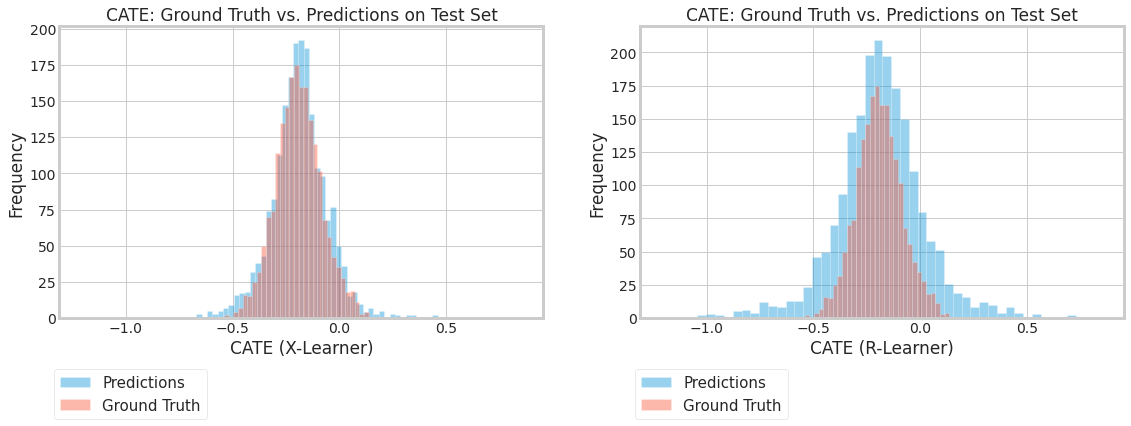


b) Simulated RCT with positive ATE:  



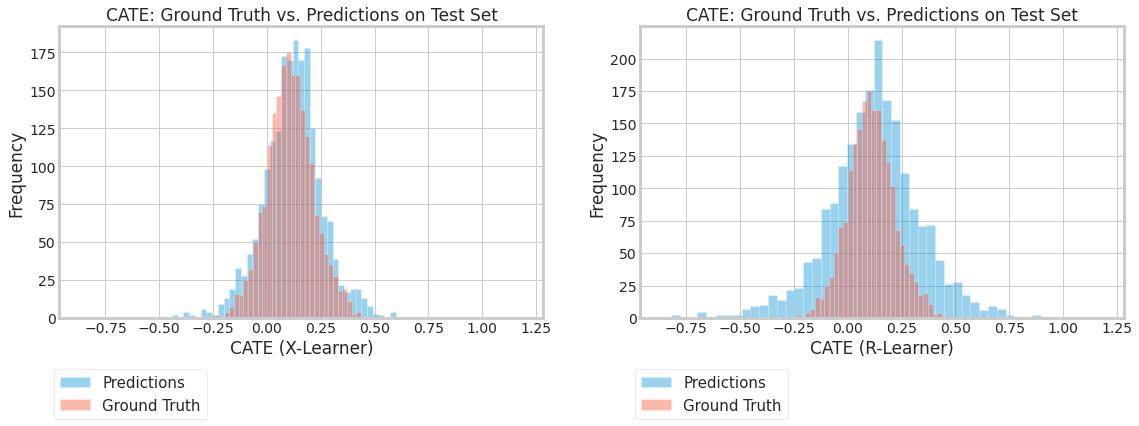


c) Simulated RCT with ATE=0.0 (approximately):  



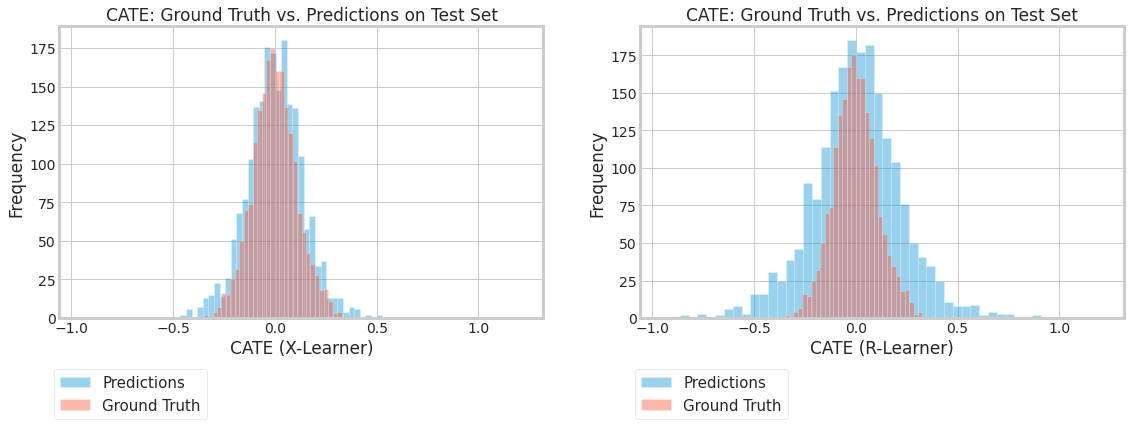

In [ ]:
#XGB-Model with n_estimators=500 is applied: in general, the higher the number of estimators, the better the results.
print("a) Simulated RCT with negative ATE: ","\n")
prediction_output_negATE=predict_cate_ate(train_set=train_test_negATE["train_data"],test_set=train_test_negATE["test_data"],
                                          #Pass the Outcome & Effect Learners to the X-Learner:
                                          xlearner_outcome_learner=XGBClassifier(n_estimators=500,objective='reg:squarederror'),
                                          xlearner_control_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                                          xlearner_treatment_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                                          #Pass the Outcome & Effect Learner to the R-Learner:
                                          rlearner_outcome_learner=XGBClassifier(n_estimators=500,objective='reg:squarederror'),
                                          rlearner_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'))

print("b) Simulated RCT with positive ATE: ","\n")
prediction_output_posATE=predict_cate_ate(train_set=train_test_posATE["train_data"],test_set=train_test_posATE["test_data"],
                                          #Pass the Outcome & Effect Learners to the X-Learner:
                                          xlearner_outcome_learner=XGBClassifier(n_estimators=500,objective='reg:squarederror'),
                                          xlearner_control_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                                          xlearner_treatment_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                                          #Pass the Outcome & Effect Learner to the R-Learner:
                                          rlearner_outcome_learner=XGBClassifier(n_estimators=500,objective='reg:squarederror'),
                                          rlearner_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'))

print("c) Simulated RCT with ATE=0.0 (approximately): ","\n")
prediction_output_noATE=predict_cate_ate(train_set=train_test_noATE["train_data"],test_set=train_test_noATE["test_data"],
                                          #Pass the Outcome & Effect Learners to the X-Learner:
                                          xlearner_outcome_learner=XGBClassifier(n_estimators=500,objective='reg:squarederror'),
                                          xlearner_control_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                                          xlearner_treatment_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                                          #Pass the Outcome & Effect Learner to the R-Learner:
                                          rlearner_outcome_learner=XGBClassifier(n_estimators=500,objective='reg:squarederror'),
                                          rlearner_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'))


In [ ]:
print("Tabular Summary of CATE & ATE Predictions: ")

Tabular Summary of CATE & ATE Predictions: 


![alt text](https://drive.google.com/uc?id=1TyvWXUdqI8QUmNZqYpUA-Tdoiclyc-gH)

**Interpretation of the Prediction Results from the fixed-time Setting**<br>
The histograms visualizing the predicted vs. true distribution of CATE on the test set show that the predictions generated by the X-Learner are more accurate compared to the predictions of the R-Learner in each of the 3 scenarios: RCT with negative ATE, positive ATE and ATE=0.0. The R-Learner predicts a distribution which has higher variance compared to the distribution of the true CATE. In addition to that, the tabular summary shows that the X-Learner achieves lower RMSE than the R-Learner on the predictions of CATE in each scenario on both the train and test dataset. This indicates that the X-Learner outperforms the R-Learner on the estimation of CATE. In this context, it is important to highlight that neither of the models shows signs of overfitting the data when predicting CATE as both models achieve similar (slightly lower) RMSE on the test set.  <br>

The table showing the APE on the predictions of ATE shows partially different results compared to the ones related to the estimation of CATE. For example, in the scenario with positive ATE the APE achieved by the X-Learner is higher than the one achieved by the R-Learner on both the train and the test dataset. This implies than the R-Learner predicts the overall treatment effect of the RCT slightly more accurate than the X-Learner. In comparison to that, as mentioned above, the X-Learner performes better at estimating the individual level treatment effect. By contrast, in the scenario with ATE=0.0, the results are similar to the ones related to the prediction of CATE. Furthermore, in each scenario both models achieve similar APE on the train and the test set (either slightly lower or slightly higher APE on the test set). In this regard, the partially inconsistent results highlight the neccessity to perform cross-validation in order to examine whether the inconsistency of the results would persist. Before we move on to the next-step, it should be noted that in general both models successfully estimate the sign of ATE in each scenario on both the train and test dataset. In addition to that, a comparison between the tables containing the values of the true ATE and the ones of the predicted ATE shows that the predictions are very close to the true values. 

#### **3.2.2. Evaluation of CATE Predictions with T-Risk Metric**

a) Simulated RCT with negative ATE:  



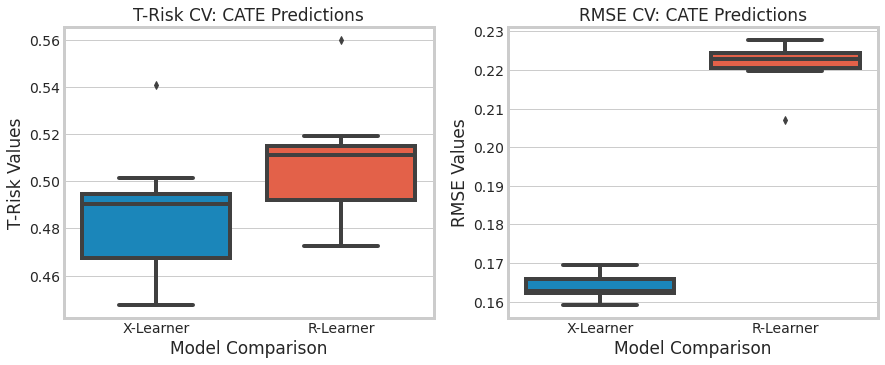




b) Simulated RCT with positive ATE:  



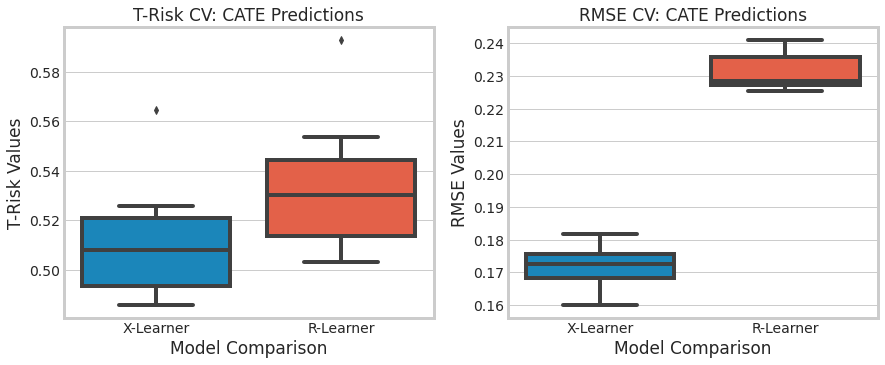




c) Simulated RCT with ATE=0.0:  



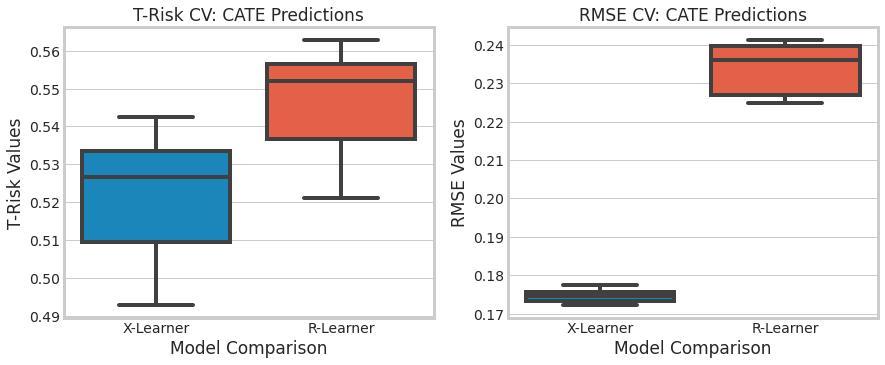

In [ ]:
print("a) Simulated RCT with negative ATE: ","\n")
cv_output_negATE=CV_results(sim_data_negATE,n_folds=10,
                            #Pass the Outcome & Effect Learners to the X-Learner:
                            xlearner_outcome_learner=XGBClassifier(n_estimators=500,objective='reg:squarederror'),
                            xlearner_control_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                            xlearner_treatment_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                            #Pass the Outcome & Effect Learner to the R-Learner:
                            rlearner_outcome_learner=XGBClassifier(n_estimators=500,objective='reg:squarederror'),
                            rlearner_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                            sample_folds=True)

print("b) Simulated RCT with positive ATE: ","\n")
cv_output_posATE=CV_results(sim_data_posATE,n_folds=10,
                            #Pass the Outcome & Effect Learners to the X-Learner:
                            xlearner_outcome_learner=XGBClassifier(n_estimators=500,objective='reg:squarederror'),
                            xlearner_control_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                            xlearner_treatment_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                            #Pass the Outcome & Effect Learner to the R-Learner:
                            rlearner_outcome_learner=XGBClassifier(n_estimators=500,objective='reg:squarederror'),
                            rlearner_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                            sample_folds=True)

print("c) Simulated RCT with ATE=0.0: ","\n")
cv_output_noATE=CV_results(sim_data_noATE,n_folds=10,
                            #Pass the Outcome & Effect Learners to the X-Learner:
                            xlearner_outcome_learner=XGBClassifier(n_estimators=500,objective='reg:squarederror'),
                            xlearner_control_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                            xlearner_treatment_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                            #Pass the Outcome & Effect Learner to the R-Learner:
                            rlearner_outcome_learner=XGBClassifier(n_estimators=500,objective='reg:squarederror'),
                            rlearner_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                            sample_folds=True)




In [ ]:
print("Tabular summary of CV Results:")

Tabular summary of CV Results:


![alt text](https://drive.google.com/uc?id=1Aa71AxXrrhrU9qkhSVj85YaVurPbU-ZN)

**Interpretation of the CV Results**<br>
The boxplots visualizing the distribution of the T-risk values from 10-Fold CV show the following:<br>
- in the scenario with negative ATE and positive ATE the T-risk value of the X-Learner associated with the 3. quartile is a little higher than the one of the R-Learner associated with the 1. quartile. This indicates an overlap between the corresponding values. Despite that fact, it can be seen, that in general the X-Learner achieves lower T-risk values than the R-Learner.
- in the scenario with ATE=0.0 the majority of the T-risk values of the X-Learner (the ones between the 1. quartile and the 3. quartile) are below the majority of the T-risk values achieved by the R-Learner.  <br>

Furthermore, the tabular summary of the CV results shows that the mean of the T-risk values of the X-Learner is lower than the mean of the T-risk values of the R-Learner in each scenario on the test set. Thus, since in practice the true distribution of CATE is not known, judging by the distribution of the T-risk values and their mean the conclusion can be made that the X-Learner outperforms the R-Learner on the prediction of CATE (the lower the T-risk, the better the model). In this context, the plots visualizing the distribution of the RMSE between the true CATE and the predicted CATE confirm that the X-Learner is the more powerfull model compared to the R-Learner in the context of predicting CATE. Furthermore, the results in terms of the average APE from 10 Folds on the prediction of ATE are consistent with the CV results of CATE: in each of the scenarios the average 10-Fold APE of the X-Learner on the test set is lower than the one of the R-Learner. As cross-validation is performed in order to obtain more reliable results, it can be concluded that the X-Learner outperforms the R-Learner on the prediction of ATE as well. Therefore, the CV results so far indicate that the T-risk metric could be used as a guidance metric for the evaluation of the CATE predictions as it produces the right signal regarding which model performs better for the estimation of individual unit treatment effects. By successfully identifying the better CATE model, we succeed in identifying the model that also performs better on the estimation of the overall treatment effect of a particular RCT. <br>

In this context, it is important to highlight that in each scenario there is  clear gap between the boxplots visualizing the distribution of the RMSE values which is not the case with the boxplots visualizing the distribution of the T-risk values. Thus, the T-risk metric as an aproximation measure cannot depict the reality completely.

#### **3.2.3. Uplift Modelling**

a) Simulated RCT with negative ATE:  



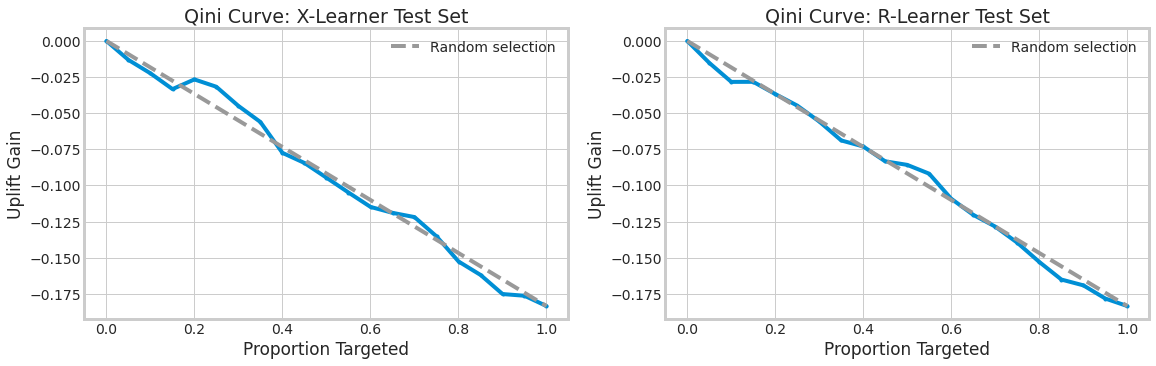




b) Simulated RCT with positive ATE:  



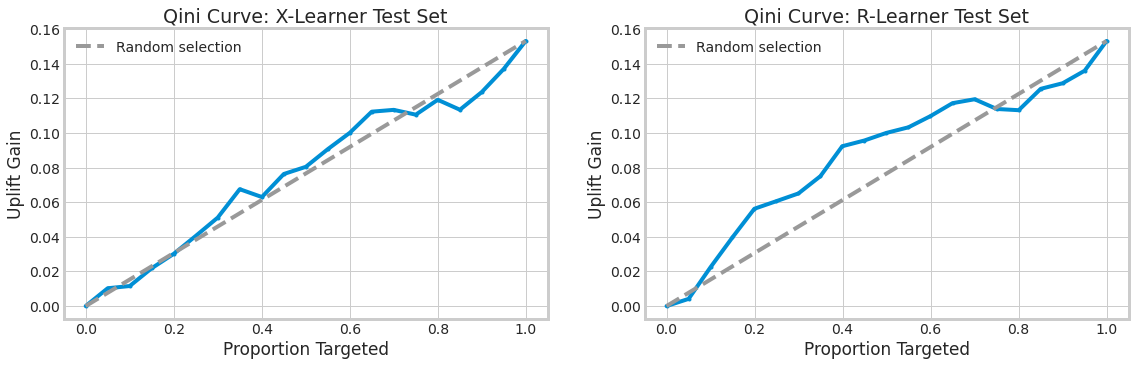




c) Simulated RCT with ATE=0.0:  



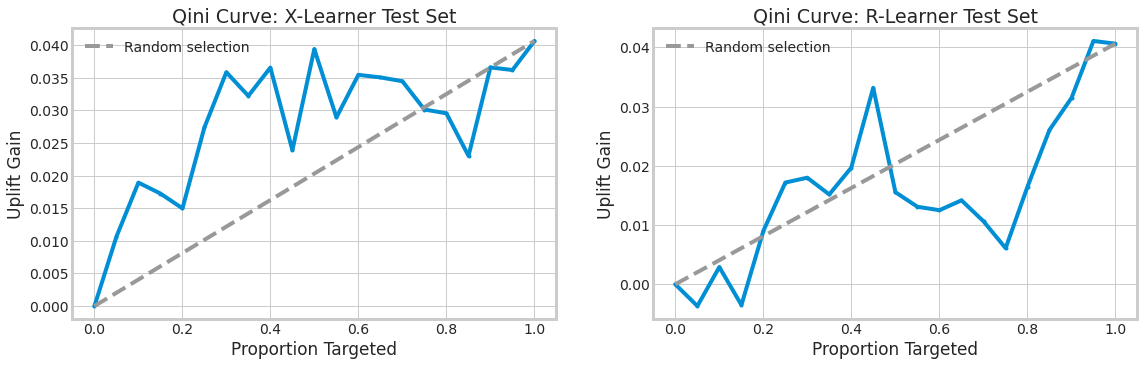

In [ ]:
print("a) Simulated RCT with negative ATE: ","\n")
qini_coefficient_output_negATE=plot_qini_curves(train_data=train_test_negATE["train_data"],
                                         test_data=train_test_negATE["test_data"],
                                         xlearner_predictions=prediction_output_negATE["predictions_xlearner"],
                                        rlearner_predictions=prediction_output_negATE["predictions_rlearner"])

print("b) Simulated RCT with positive ATE: ","\n")
qini_coefficient_output_posATE=plot_qini_curves(train_data=train_test_posATE["train_data"],
                                         test_data=train_test_posATE["test_data"],
                                         xlearner_predictions=prediction_output_posATE["predictions_xlearner"],
                                        rlearner_predictions=prediction_output_posATE["predictions_rlearner"])

print("c) Simulated RCT with ATE=0.0: ","\n")
qini_coefficient_output_noATE=plot_qini_curves(train_data=train_test_noATE["train_data"],
                                         test_data=train_test_noATE["test_data"],
                                         xlearner_predictions=prediction_output_noATE["predictions_xlearner"],
                                        rlearner_predictions=prediction_output_noATE["predictions_rlearner"])




In [ ]:
print("Tabular Summary of Qini Coefficient on Train & Test Set before Hyperparameter Tuning: ")

Tabular Summary of Qini Coefficient on Train & Test Set: 


![alt text](https://drive.google.com/uc?id=1bBn7ZLX8jIFkYaJVmRJ0vnwU3mqImOS5)

**Interpretation of the Qini Curves**<br>
The Qini Curves of both the X-Learner and the R-Learner in each scenario come very close to the random curve (and cross it). Both models achieve an Area under the Qini Curve on the test set close to app. 0.0, in some cases even below 0.0. In addition to that, both models overfit the data when evaluated on the qini coefficient as the qini score achieved by both models on the train data in each scenario is much higher than the one on the test data. Thus, the conclusion that could be made is that the models are expected to perform poor when targetting new customers based on their uplift. However, as we have seen above, both models predict the distribution of CATE successfully (the X-Learner slightly better). Thus, it is questionable whether the qini coefficient could truly be used as an evaluation criteria for the performance of uplift models.<br> 

**Hyperparameter Tuning: Evaluation Criteria=Area under the Qini Curve**<br>

In [ ]:
#Hyperparameter Optimization:

#RCT with negative ATE:
#X-Learner:
hp_negATE=hyperparameter_tuning(train_set=train_test_negATE["train_data"],
                                 test_set=train_test_negATE["test_data"],
                                 learner_to_test="X-Learner",
                                 num_trials=100)
results_hp_negATE_x=hp_negATE.run_study()

#R-Learner:
hp_negATE=hyperparameter_tuning(train_set=train_test_negATE["train_data"],
                                 test_set=train_test_negATE["test_data"],
                                 learner_to_test="R-Learner",
                                 num_trials=100)
results_hp_negATE_r=hp_negATE.run_study()

#RCT with positive ATE:
#X-Learner:
hp_posATE=hyperparameter_tuning(train_set=train_test_posATE["train_data"],
                                 test_set=train_test_posATE["test_data"],
                                 learner_to_test="X-Learner",
                                 num_trials=100)
results_hp_posATE_x=hp_negATE.run_study()

#R-Learner:
hp_posATE=hyperparameter_tuning(train_set=train_test_posATE["train_data"],
                                 test_set=train_test_posATE["test_data"],
                                 learner_to_test="R-Learner",
                                 num_trials=100)
results_hp_posATE_r=hp_negATE.run_study()

#RCT with ATE=0.0:
#X-Learner:
hp_noATE=hyperparameter_tuning(train_set=train_test_noATE["train_data"],
                                 test_set=train_test_noATE["test_data"],
                                 learner_to_test="X-Learner",
                                 num_trials=100)
results_hp_noATE_x=hp_noATE.run_study()

#R-Learner:
hp_noATE=hyperparameter_tuning(train_set=train_test_noATE["train_data"],
                                 test_set=train_test_noATE["test_data"],
                                 learner_to_test="R-Learner",
                                 num_trials=100)
results_hp_noATE_r=hp_noATE.run_study()

Once 100 Trials are ran on each scenario with the X-Learner and the R-Learner, the optimal hyperparameters are extracted and applied in the models.

In [22]:
print("Tabular Summary of Qini Coefficient after Hyperparameter Tuning")

Tabular Summary of Qini Coefficient after Hyperparameter Tuning


![alt text](https://drive.google.com/uc?id=14OWb4lxUx_k2bBowunWjvN_cSbYC-t__)

Results after Hyperparameter Tuning on the entire dataset:  

a) Simulated RCT with negative ATE:  



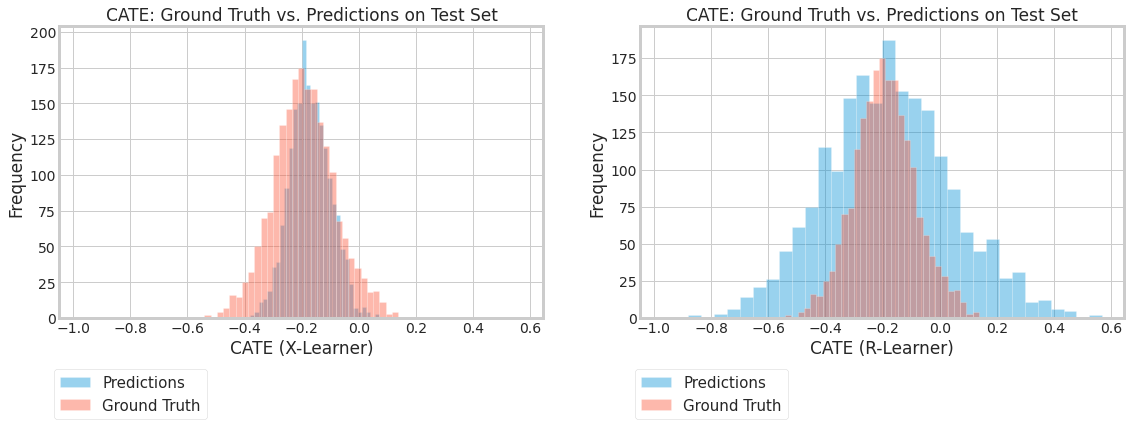


b) Simulated RCT with positive ATE:  



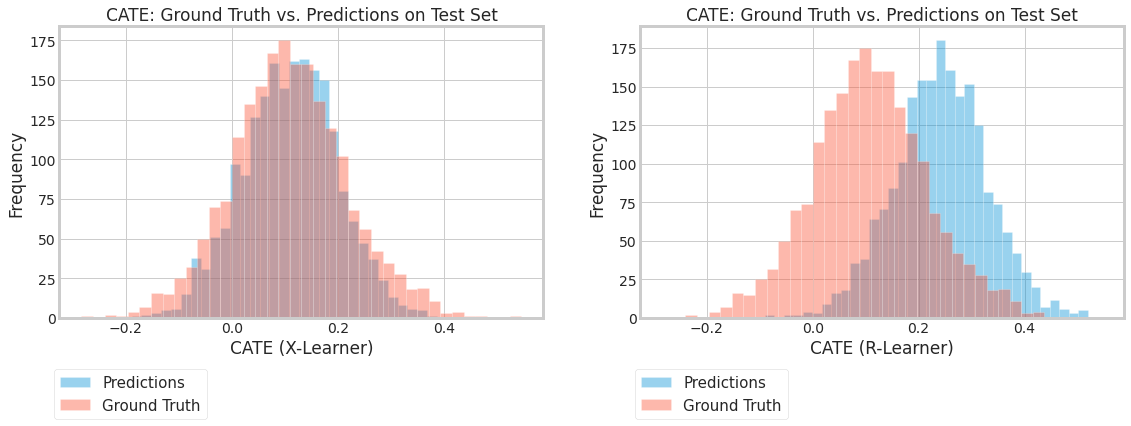


c) Simulated RCT with ATE=0.0 (approximately):  



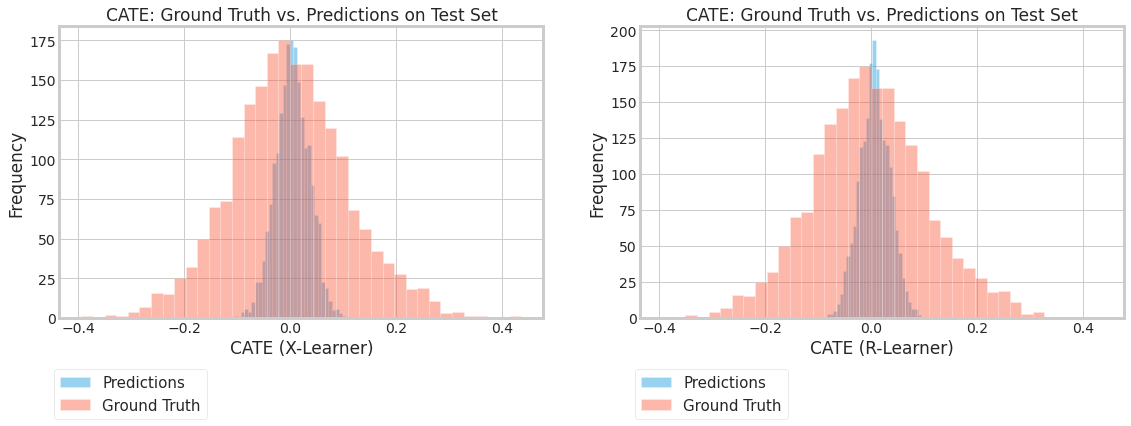

In [ ]:
print("Results after Hyperparameter Tuning on the entire dataset: ","\n")
print("a) Simulated RCT with negative ATE: ","\n")

prediction_output_negATE=predict_cate_ate(train_set=train_test_negATE["train_data"],test_set=train_test_negATE["test_data"],
                                          #Pass the Outcome & Effect Learners to the X-Learner:
                                          xlearner_outcome_learner=XGBClassifier(max_depth=130, 
                                                                                 learning_rate=0.03,n_estimators=400,
                                                                                 booster="gbtree",colsample_bytree=0.5,
                                                                                 reg_alpha=0.0,reg_lambda=0.044,
                                                                                 importance_type="weight",objective='reg:squarederror'),
                                          xlearner_control_effect_learner=XGBRegressor(max_depth=130, 
                                                                                 learning_rate=0.03,n_estimators=400,
                                                                                 booster="gbtree",colsample_bytree=0.5,
                                                                                 reg_alpha=0.0,reg_lambda=0.044,
                                                                                 importance_type="weight",objective='reg:squarederror'),
                                          xlearner_treatment_effect_learner=XGBRegressor(max_depth=130, 
                                                                                 learning_rate=0.03,n_estimators=400,
                                                                                 booster="gbtree",colsample_bytree=0.5,
                                                                                 reg_alpha=0.0,reg_lambda=0.044,
                                                                                 importance_type="weight",objective='reg:squarederror'),
                                          
                                          #Pass the Outcome & Effect Learner to the R-Learner:
                                          rlearner_outcome_learner=XGBClassifier(max_depth=980, 
                                                                                 learning_rate=0.0455,n_estimators=650,
                                                                                 booster="gbtree",colsample_bytree=0.5,
                                                                                 reg_alpha=0.0,reg_lambda=0.233,
                                                                                 importance_type="total_gain",objective='reg:squarederror'),
                                          rlearner_effect_learner=XGBRegressor(max_depth=980, 
                                                                                 learning_rate=0.0455,n_estimators=650,
                                                                                 booster="gbtree",colsample_bytree=0.5,
                                                                                 reg_alpha=0.0,reg_lambda=0.233,
                                                                                 importance_type="total_gain",objective='reg:squarederror'))


print("b) Simulated RCT with positive ATE: ","\n")
prediction_output_posATE=predict_cate_ate(train_set=train_test_posATE["train_data"],test_set=train_test_posATE["test_data"],
                                          #Pass the Outcome & Effect Learners to the X-Learner:
                                          xlearner_outcome_learner=XGBClassifier(max_depth=500, 
                                                                                 learning_rate=0.0817,n_estimators=600,
                                                                                 booster="gbtree",colsample_bytree=0.5,
                                                                                 reg_alpha=0.0,reg_lambda=0.165,
                                                                                 importance_type="total_cover",objective='reg:squarederror'),
                                          xlearner_control_effect_learner=XGBRegressor(max_depth=500, 
                                                                                 learning_rate=0.0817,n_estimators=600,
                                                                                 booster="gbtree",colsample_bytree=0.5,
                                                                                 reg_alpha=0.0,reg_lambda=0.165,
                                                                                 importance_type="total_cover",objective='reg:squarederror'),
                                          xlearner_treatment_effect_learner=XGBRegressor(max_depth=500, 
                                                                                 learning_rate=0.0817,n_estimators=600,
                                                                                 booster="gbtree",colsample_bytree=0.5,
                                                                                 reg_alpha=0.0,reg_lambda=0.165,
                                                                                 importance_type="total_cover",objective='reg:squarederror'),
                                          
                                          #Pass the Outcome & Effect Learner to the R-Learner:
                                          rlearner_outcome_learner=XGBClassifier(max_depth=840, 
                                                                                 learning_rate=0.0024,n_estimators=550,
                                                                                 booster="gbtree",colsample_bytree=0.4,
                                                                                 reg_alpha=0.0,reg_lambda=0.254,
                                                                                 importance_type="gain",objective='reg:squarederror'),
                                          rlearner_effect_learner=XGBRegressor(max_depth=840, 
                                                                                 learning_rate=0.0024,n_estimators=550,
                                                                                 booster="gbtree",colsample_bytree=0.4,
                                                                                 reg_alpha=0.0,reg_lambda=0.254,
                                                                                 importance_type="gain",objective='reg:squarederror'))


print("c) Simulated RCT with ATE=0.0 (approximately): ","\n")
prediction_output_noATE=predict_cate_ate(train_set=train_test_noATE["train_data"],test_set=train_test_noATE["test_data"],
                                          #Pass the Outcome & Effect Learners to the X-Learner:
                                          xlearner_outcome_learner=XGBClassifier(max_depth=880, 
                                                                                 learning_rate=0.0487,n_estimators=700,
                                                                                 booster="gblinear",colsample_bytree=0.6,
                                                                                 reg_alpha=0.0,reg_lambda=0.074,
                                                                                 importance_type="total_cover",objective='reg:squarederror'),
                                          xlearner_control_effect_learner=XGBRegressor(max_depth=880, 
                                                                                 learning_rate=0.0487,n_estimators=700,
                                                                                 booster="gblinear",colsample_bytree=0.6,
                                                                                 reg_alpha=0.0,reg_lambda=0.074,
                                                                                 importance_type="total_cover",objective='reg:squarederror'),
                                          xlearner_treatment_effect_learner=XGBRegressor(max_depth=880, 
                                                                                 learning_rate=0.0487,n_estimators=700,
                                                                                 booster="gblinear",colsample_bytree=0.6,
                                                                                 reg_alpha=0.0,reg_lambda=0.074,
                                                                                 importance_type="total_cover",objective='reg:squarederror'),
                                         
                                          #Pass the Outcome & Effect Learner to the R-Learner:
                                          rlearner_outcome_learner=XGBClassifier(max_depth=960, 
                                                                                 learning_rate=0.0113,n_estimators=900,
                                                                                 booster="gblinear",colsample_bytree=0.3,
                                                                                 reg_alpha=0.0,reg_lambda= 0.195,
                                                                                 importance_type="total_cover",objective='reg:squarederror'),
                                          rlearner_effect_learner=XGBRegressor(max_depth=960, 
                                                                                 learning_rate=0.0113,n_estimators=900,
                                                                                 booster="gblinear",colsample_bytree=0.3,
                                                                                 reg_alpha=0.0,reg_lambda= 0.195,
                                                                                 importance_type="total_cover",objective='reg:squarederror'))

**Interpretation of the Results after Hyperparameter Optimization**<br>
The tabular summary of the qini coefficient after the hyperparameter optimization shows that no improvement is achieved in terms of the Area under the Qini Curve. In some cases, for example in the scenario with negative ATE the qini coefficient on the test set before the hyperparameter tuning is slightly positive and after it slightly negative. This implies that sometimes the models perform better with their default hyperparameters. Furthermore, the histograms show that in some cases no significant difference can be established between the distribution of the predicted CATE before and after hyperparameter tuning: for example the predicted distribution of CATE by the X-Learner in the scenario with positive ATE. By contrast, after hyperparameter tuning the predicted distribution by the R-Learner in this scenario is shifted more to the right compared to the true CATE. Furthermore, in the scenario ATE=0.0 both models underestimate CATE after the hyperparameter tuning. This implies that no specific conclusion can be made whether optimizing with respect to the qini coefficient leads to more or less accurate estimation of CATE.

#### **3.3. Sequential Setting**
The sequential setting covers covers two variations of sequential testing: <br>
- **E-Mail Campaign**<br> 
We assume a marketing manager wants to test for example if customers would buy more from a new product in case they receive an e-mail with a voucher. For this purpose, the manager takes all customers in the entire database and randomly assigns 50% to the treatment group and the rest 50% to the control group. Then, the manager sends out e-mails to all customers in the treatment group on the same day, for example at the beginning of a week (monday). Due to particular time constraints in practice, we assume the manager continuously monitors the "responses" from the customers during the period of one week at the longest in order to estimate the effect of the treatment. By "responses" is meant whether the customer converged (bought the new product) or did not converge. Furthermore, we assume a time dependent pattern in the responses of the customers: for example on some days more women respond while on others more men respond. <br><br>
- **Sequential A/B Testing**<br>
In sequential A/B testing a marketing manager would pick a particular proportion of customers from the entire database at each time step, for example every day, and would use only this fraction for testing which variant is better, A or B. We assume that the fraction of customers is randomly taken from database and that it is distinct at each time step. An important difference to the sequential setting where e-mail campaign is ran is that the manager has control over the amount of data used for the sequential monitoring at each time step. Again with sequential A/B testing, there is a particular time constraint limiting the period of time for the continuous monitoring, for example a week. 

#### **3.3.1. E-Mail Campaign**
The velocity of the response flow plays an important role in the simulation of the e-mail campaign described above. In general, in practive it is possible that the majority of the responses flow in on the same day when the e-mails were sent out. In this case, the prediction results in terms of CATE and ATE would be quite similar to the ones from the fixed-time setting as on the very first day of the sequential testing, we would have access to the bigger part of the data. By contrast, the setting in which a small proportion of the responses flow in at the beggining of the week would be more challenging for the estimation of CATE & ATE. As the aim of our topic is to highlight the challenges marketing practitioners face when estimating treatment effects, we will focus in this section on the later. 

In [ ]:
time_steps=["Monday","Tuesday","Wednesday","Thursday","Friday"]

response_frame_negATE=simulate_email_responses(sim_data=sim_data_negATE,
                                        time_steps=time_steps,
                                        seed_responses_women=130,
                                        seed_responses_men=158,
                                        print_output=True)#41

response_frame_posATE=simulate_email_responses(sim_data=sim_data_posATE,
                                        time_steps=time_steps,
                         seed_responses_women=130,
                         seed_responses_men=158,
                         print_output=False)#41

response_frame_noATE=simulate_email_responses(sim_data=sim_data_noATE,
                                        time_steps=time_steps,
                         seed_responses_women=130,
                         seed_responses_men=158,
                         print_output=False)#41

Fraction Responses flowing in on: 
-  Monday :  12 %
   (the current fraction= 1239  number of responses, from which: women= 839 , men= 400 ) 

-  Tuesday :  22 %
   (the current fraction= 2178  number of responses, from which: women= 1618 , men= 560 ) 

-  Wednesday :  37 %
   (the current fraction= 3740  number of responses, from which: women= 1978 , men= 1762 ) 

-  Thursday :  9 %
   (the current fraction= 899  number of responses, from which: women= 179 , men= 720 ) 

-  Friday :  20 %
   (the current fraction= 1944  number of responses, from which: women= 1381 , men= 563 ) 



We can see from the simulated flow that on Monday, Tuesday and Friday more women than men respond (approximately twice more or even three times more women). On Wednesday approximately equal amount of women and men respond (number of women is slightly higher). By contrast, on Thursday more men than women respond. Next, we will examine which is the earliest day on which we can stop the sequential test starting from monday and still come to the same conclusion had we waited till the end of the week. For this reason, we will compare the results from this setting to the ones from the fixed-time one (the benchmark setting).

In [ ]:
print("Splitting Responses Flow from Monday in Train & Test Set")
train_test_negATE=split_train_test(sim_data=response_frame_negATE[0])

train_test_posATE=split_train_test(sim_data=response_frame_posATE[0])

train_test_noATE=split_train_test(sim_data=response_frame_noATE[0])

Splitting Responses Flow from Monday in Train & Test Set


#### **3.3.1.1. Predictions: ATE & CATE**

The Results are presented for the first Time Step (Monday) 

a) Simulated RCT with negative ATE:  



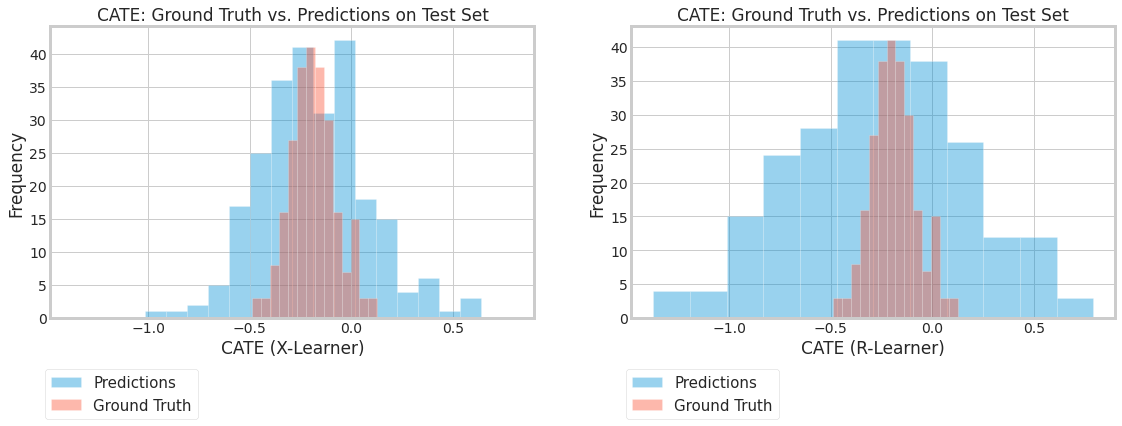


b) Simulated RCT with positive ATE:  



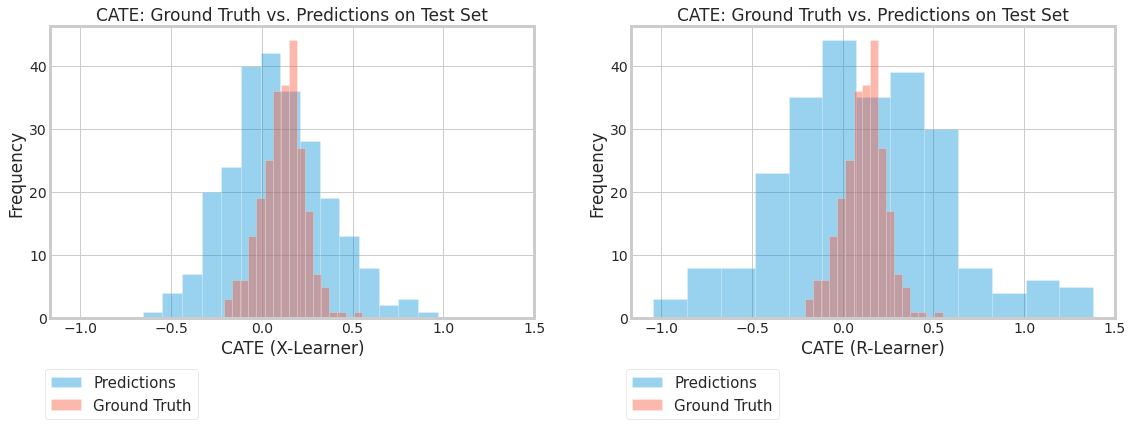


c) Simulated RCT with ATE=0.0 (approximately):  



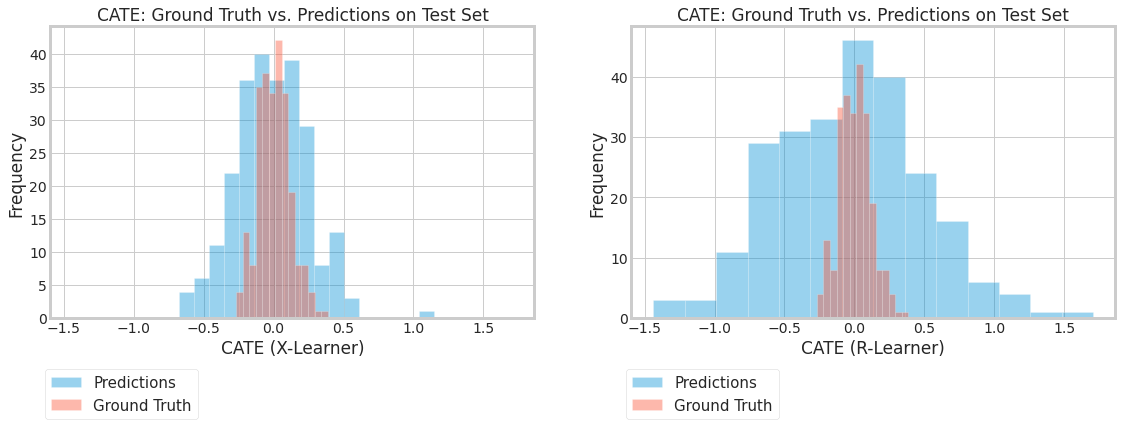

In [ ]:
print("The Results are presented for the first Time Step (Monday)","\n")
print("a) Simulated RCT with negative ATE: ","\n")
prediction_output_negATE=predict_cate_ate(train_set=train_test_negATE["train_data"],test_set=train_test_negATE["test_data"],
                                          #Pass the Outcome & Effect Learners to the X-Learner:
                                          xlearner_outcome_learner=XGBClassifier(n_estimators=500,objective='reg:squarederror'),
                                          xlearner_control_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                                          xlearner_treatment_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                                          #Pass the Outcome & Effect Learner to the R-Learner:
                                          rlearner_outcome_learner=XGBClassifier(n_estimators=500,objective='reg:squarederror'),
                                          rlearner_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'))

print("b) Simulated RCT with positive ATE: ","\n")
prediction_output_posATE=predict_cate_ate(train_set=train_test_posATE["train_data"],test_set=train_test_posATE["test_data"],
                                          #Pass the Outcome & Effect Learners to the X-Learner:
                                          xlearner_outcome_learner=XGBClassifier(n_estimators=500,objective='reg:squarederror'),
                                          xlearner_control_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                                          xlearner_treatment_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                                          #Pass the Outcome & Effect Learner to the R-Learner:
                                          rlearner_outcome_learner=XGBClassifier(n_estimators=500,objective='reg:squarederror'),
                                          rlearner_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'))

print("c) Simulated RCT with ATE=0.0 (approximately): ","\n")
prediction_output_noATE=predict_cate_ate(train_set=train_test_noATE["train_data"],test_set=train_test_noATE["test_data"],
                                          #Pass the Outcome & Effect Learners to the X-Learner:
                                          xlearner_outcome_learner=XGBClassifier(n_estimators=500,objective='reg:squarederror'),
                                          xlearner_control_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                                          xlearner_treatment_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                                          #Pass the Outcome & Effect Learner to the R-Learner:
                                          rlearner_outcome_learner=XGBClassifier(n_estimators=500,objective='reg:squarederror'),
                                          rlearner_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'))

In [ ]:
print("Tabular Summary of CATE & ATE Predictions for the first Time Step (Monday): ")

Tabular Summary of CATE & ATE Predictions for the first Time Step (Monday): 


![alt text](https://drive.google.com/uc?id=1QVecI8B8CgS3YUSi_58nrq0lgC_2VR7Y)

**Interpretation of the Prediction Results from the sequential Setting (E-Mail Campaign)**<br>
The histograms visualizing the distribution of the predicted CATE vs. the true CATE on the test set show that both the X-Learner and the R-Learner predict a dsitribution that has a higher variance than the true one in each scenario. By contrast, in the fixed-time setting this problem occurred only in the predictions of the R-Learner. Furthermore, the histograms also show that the variance of the predictions of the R-Learner is higher than the variance of the predictions of the X-Learner. This leads to the conclusion that among the two models the X-Learner generates more accuarate predictions of CATE than the R-Learner. The table containing the RMSE values on the CATE predictions confirms that the X-Learner ahcieves a lower error on both the train and test set than the R-Learner in each scenario. In the benchmark setting the comparison between the performance of the two models lead to the same conclusion in each scenario. It is important to highlight, that a comparison between the RMSE values from the current setting to the ones in the benchmark setting shows an increase in error achieved by both models on the train and test set. <br>

The table containing the APE on the predictions of ATE shows similarly to the bechmark setting partially inconsistent results when compared to the CATE results. In the scenario with positive ATE the R-Learner achieves a lower error than the X-Learner on the prediction of ATE on both the train and test set. By contrast, in the scenario with negative ATE the X-Learner outperforms the R-Learner on the estimation of ATE based on the error values on the train and test set. Furthermore, in the scenario with true ATE=0.0 both models fail in predicting the correct sign of ATE: the absolute value of the predicted ATE is approximately 0.0, but the models predict ATE with negative sign. Therefore,  in the next step cross-validation will be performed in order to control whether we could obtain more consistent results and also come to the same conclusion in each scenario had we kept on monitoring the customer responses till the end of the week.



#### **3.3.1.2. Evaluation of CATE Predictions with T-Risk Metric**

a) Simulated RCT with negative ATE:  



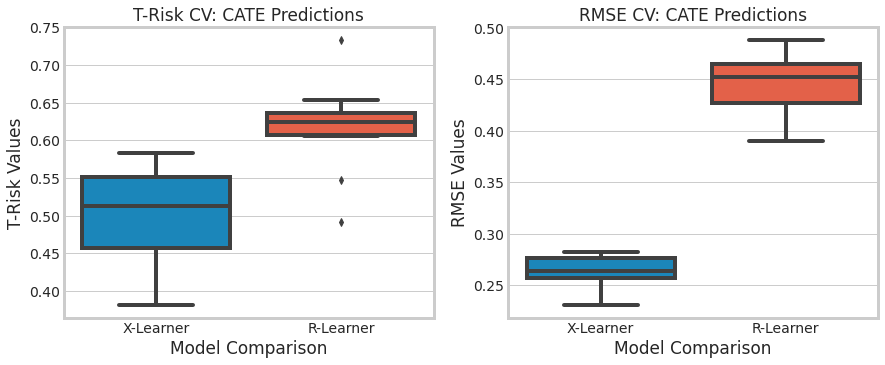




b) Simulated RCT with positive ATE:  



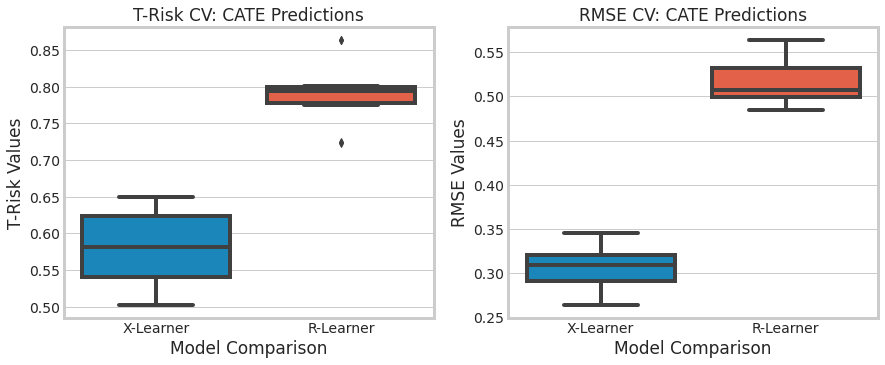




c) Simulated RCT with ATE=0.0:  



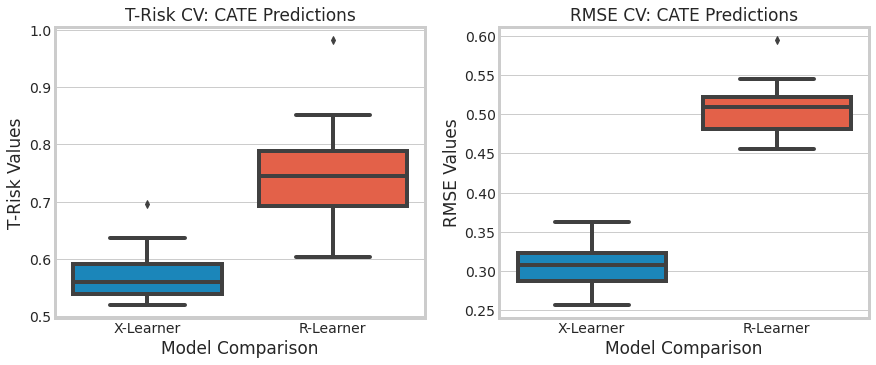

In [ ]:
print("a) Simulated RCT with negative ATE: ","\n")
cv_output_negATE=CV_results(relevant_data=response_frame_negATE[0],n_folds=10,
                            #Pass the Outcome & Effect Learners to the X-Learner:
                            xlearner_outcome_learner=XGBClassifier(n_estimators=500,objective='reg:squarederror'),
                            xlearner_control_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                            xlearner_treatment_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                            #Pass the Outcome & Effect Learner to the R-Learner:
                            rlearner_outcome_learner=XGBClassifier(n_estimators=500,objective='reg:squarederror'),
                            rlearner_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                            sample_folds=True)

print("b) Simulated RCT with positive ATE: ","\n")
cv_output_posATE=CV_results(relevant_data=response_frame_posATE[0],n_folds=10,
                            #Pass the Outcome & Effect Learners to the X-Learner:
                            xlearner_outcome_learner=XGBClassifier(n_estimators=500,objective='reg:squarederror'),
                            xlearner_control_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                            xlearner_treatment_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                            #Pass the Outcome & Effect Learner to the R-Learner:
                            rlearner_outcome_learner=XGBClassifier(n_estimators=500,objective='reg:squarederror'),
                            rlearner_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                            sample_folds=True)

print("c) Simulated RCT with ATE=0.0: ","\n")
cv_output_noATE=CV_results(relevant_data=response_frame_noATE[0],n_folds=10,
                           #Pass the Outcome & Effect Learners to the X-Learner:
                           xlearner_outcome_learner=XGBClassifier(n_estimators=500,objective='reg:squarederror'),
                           xlearner_control_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                           xlearner_treatment_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                           #Pass the Outcome & Effect Learner to the R-Learner:
                           rlearner_outcome_learner=XGBClassifier(n_estimators=500,objective='reg:squarederror'),
                           rlearner_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                           sample_folds=True)

In [ ]:
print("Tabular summary of CV Results:")

Tabular summary of CV Results:


![alt text](https://drive.google.com/uc?id=13MaE5G0x2cRMh2G6OeuIcbdqnYsG1rQg)

**Interpretation of the CV Results**<br>

The boxplots visualizing the distribution of the T-risk values show that in each of the scenarios the majority of the T-risk values of the X-Learner are below the ones of the R-Learner. This was not the case in each scenario in the fixed-timed setting. Furthermore, the tabular summary shows tha the mean of the T-risk values of the X-Learner from 10-Fold CV is always lower than the one of the R-Learner. Therefore, similarly to the benchmark setting, in the current one we can also conclude based on the T-risk values that the X-Learner outperforms the R-Learner on the prediction of CATE. The mean of the RMSE values also confirms this. In addition to that, the mean of the APE of the X-Learner is also lower than the one of the R-Learner in each scenario which implies that the X-Learner outperforms the R-Learner on the prediction of ATE as well. Therefore, even when using less data compared to the benchmark setting we can still come to the same conclusions. Thus, we can stop the sequential test on moday. In this regard, it has to be noted that the error values achieved in the current setting from the 10-Fold CV are higher than the ones achieved in the benchmark setting. This is intuitive as by using the response flow only from monday we use only 12% from all responses that could have been gathered had we waited till the end of the week.  


#### **3.3.1.3. Uplift Modelling**

a) Simulated RCT with negative ATE:  



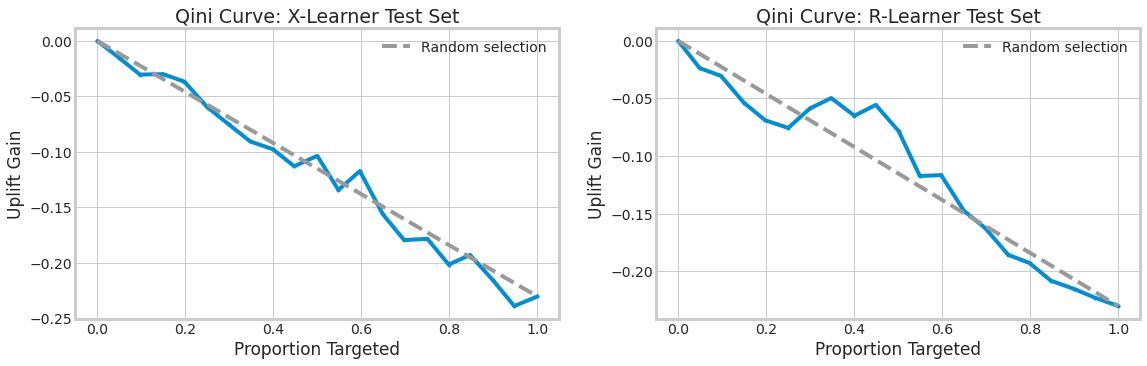




b) Simulated RCT with positive ATE:  



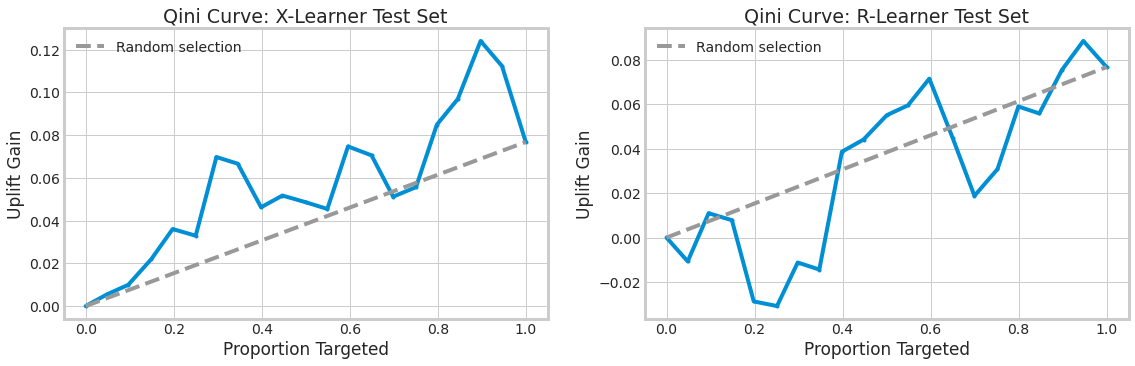




c) Simulated RCT with ATE=0.0:  



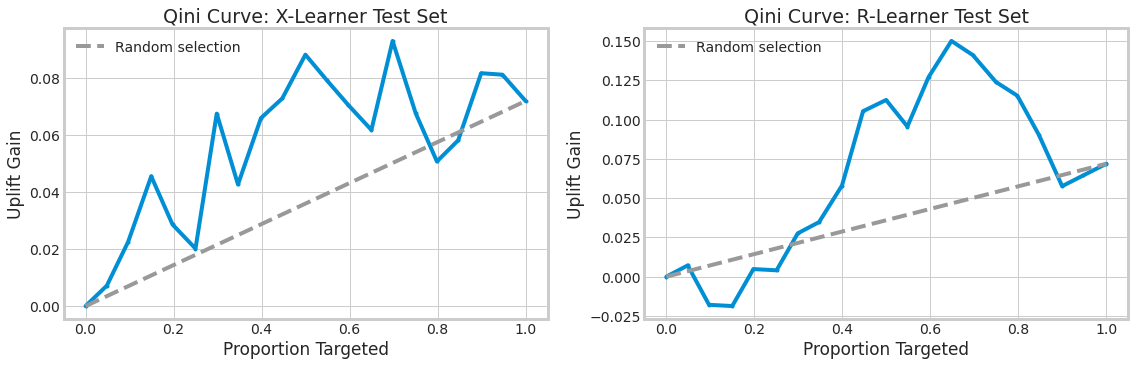

In [ ]:
print("a) Simulated RCT with negative ATE: ","\n")
qini_coefficient_output_negATE=plot_qini_curves(train_data=train_test_negATE["train_data"],
                                         test_data=train_test_negATE["test_data"],
                                         xlearner_predictions=prediction_output_negATE["predictions_xlearner"],
                                        rlearner_predictions=prediction_output_negATE["predictions_rlearner"])

print("b) Simulated RCT with positive ATE: ","\n")
qini_coefficient_output_posATE=plot_qini_curves(train_data=train_test_posATE["train_data"],
                                         test_data=train_test_posATE["test_data"],
                                         xlearner_predictions=prediction_output_posATE["predictions_xlearner"],
                                        rlearner_predictions=prediction_output_posATE["predictions_rlearner"])

print("c) Simulated RCT with ATE=0.0: ","\n")
qini_coefficient_output_noATE=plot_qini_curves(train_data=train_test_noATE["train_data"],
                                         test_data=train_test_noATE["test_data"],
                                         xlearner_predictions=prediction_output_noATE["predictions_xlearner"],
                                        rlearner_predictions=prediction_output_noATE["predictions_rlearner"])

In [ ]:
print("Tabular Summary of Qini Coefficient on Train & Test Set before Hyperparameter Tuning: ")

![alt text](https://drive.google.com/uc?id=1mjVnVmCFYv3JyB2q9FRTtXr8JuLoACwa)


**Interpretation of the Qini Curves**<br>
The results in this setting are very similar to the ones from the benchmark setting: the models achieve a very low or negative qini coefficient on the test set and also overfit the data when the evaluation criteria is the Area under the Qini Curve as there is a huge gap between the performance on the train and the test set.

**Hyperparameter Tuning: Evaluation Criteria=Area under the Qini Curve**<br>

In [ ]:
#Hyperparameter Optimization:

#RCT with negative ATE:
#X-Learner:
hp_negATE=hyperparameter_tuning(train_set=train_test_negATE["train_data"],
                                 test_set=train_test_negATE["test_data"],
                                 learner_to_test="X-Learner",
                                 num_trials=100)
results_hp_negATE_x=hp_negATE.run_study()

#R-Learner:
hp_negATE=hyperparameter_tuning(train_set=train_test_negATE["train_data"],
                                 test_set=train_test_negATE["test_data"],
                                 learner_to_test="R-Learner",
                                 num_trials=100)
results_hp_negATE_r=hp_negATE.run_study()

#RCT with positive ATE:
#X-Learner:
hp_posATE=hyperparameter_tuning(train_set=train_test_posATE["train_data"],
                                 test_set=train_test_posATE["test_data"],
                                 learner_to_test="X-Learner",
                                 num_trials=100)
results_hp_posATE_x=hp_negATE.run_study()

#R-Learner:
hp_posATE=hyperparameter_tuning(train_set=train_test_posATE["train_data"],
                                 test_set=train_test_posATE["test_data"],
                                 learner_to_test="R-Learner",
                                 num_trials=100)
results_hp_posATE_r=hp_negATE.run_study()

#RCT with ATE=0.0:
#X-Learner:
hp_noATE=hyperparameter_tuning(train_set=train_test_noATE["train_data"],
                                 test_set=train_test_noATE["test_data"],
                                 learner_to_test="X-Learner",
                                 num_trials=100)
results_hp_noATE_x=hp_noATE.run_study()

#R-Learner:
hp_noATE=hyperparameter_tuning(train_set=train_test_noATE["train_data"],
                                 test_set=train_test_noATE["test_data"],
                                 learner_to_test="R-Learner",
                                 num_trials=100)
results_hp_noATE_r=hp_noATE.run_study()




In [ ]:
print("Tabular Summary of Qini Coefficient after Hyperparameter Tuning")

Tabular Summary of Qini Coefficient after Hyperparameter Tuning


![alt text](https://drive.google.com/uc?id=1kEPRgVZzQo_2TYmPWfD_R5eSjpWSYygh)


Results after Hyperparameter Tuning on the data from Monday:  

a) Simulated RCT with negative ATE:  



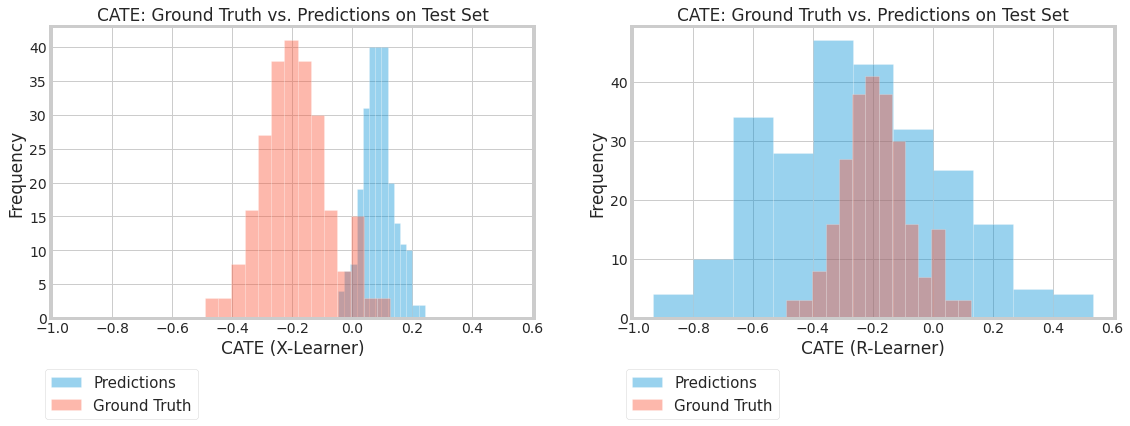


b) Simulated RCT with positive ATE:  



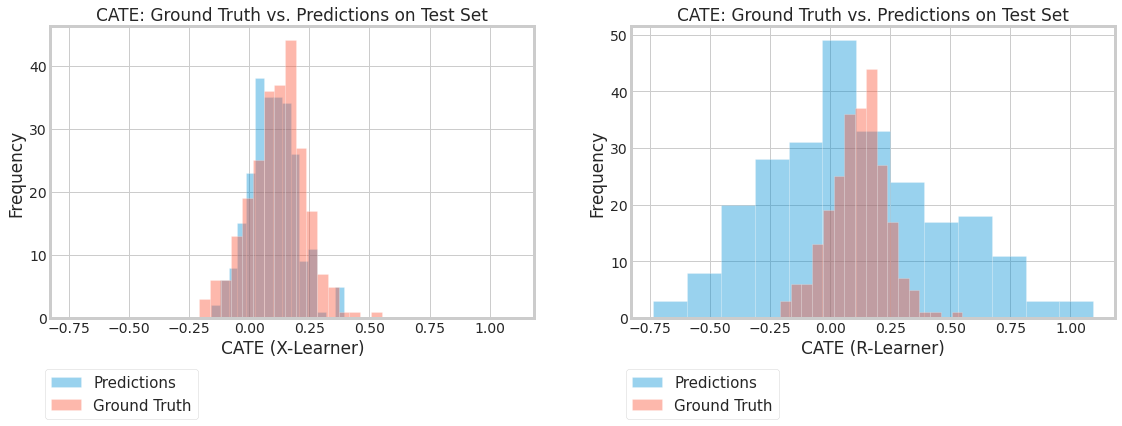


c) Simulated RCT with ATE=0.0 (approximately):  



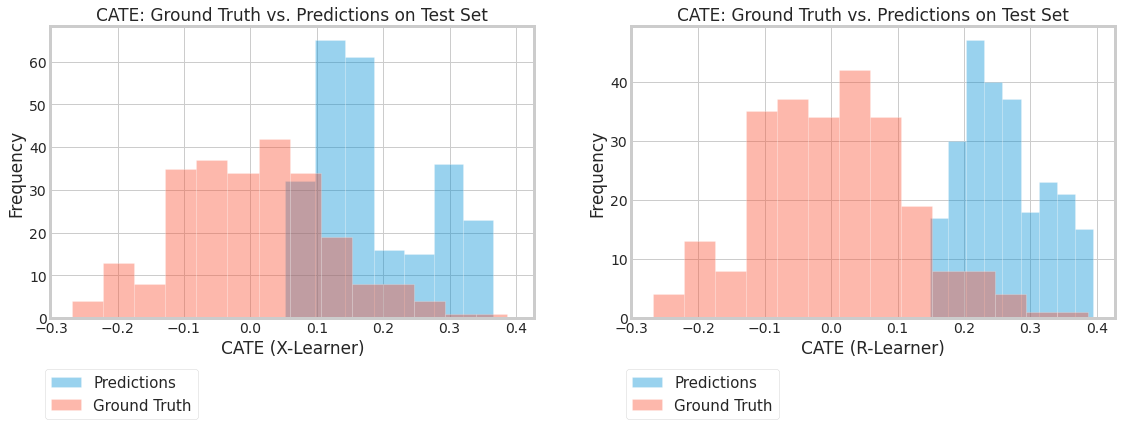

In [ ]:
print("Results after Hyperparameter Tuning on the data from Monday: ","\n")
print("a) Simulated RCT with negative ATE: ","\n")

prediction_output_negATE=predict_cate_ate(train_set=train_test_negATE["train_data"],test_set=train_test_negATE["test_data"],
                                          #Pass the Outcome & Effect Learners to the X-Learner:
                                          xlearner_outcome_learner=XGBClassifier(max_depth=660, 
                                                                                 learning_rate=0.0017,n_estimators=600,
                                                                                 booster="gbtree",colsample_bytree=0.4,
                                                                                 reg_alpha=0.0,reg_lambda=0.239,
                                                                                 importance_type="total_gain",objective='reg:squarederror'),
                                          xlearner_control_effect_learner=XGBRegressor(max_depth=660, 
                                                                                 learning_rate=0.0017,n_estimators=600,
                                                                                 booster="gbtree",colsample_bytree=0.4,
                                                                                 reg_alpha=0.0,reg_lambda=0.239,
                                                                                 importance_type="total_gain",objective='reg:squarederror'),
                                          xlearner_treatment_effect_learner=XGBRegressor(max_depth=660, 
                                                                                 learning_rate=0.0017,n_estimators=600,
                                                                                 booster="gbtree",colsample_bytree=0.4,
                                                                                 reg_alpha=0.0,reg_lambda=0.239,
                                                                                 importance_type="total_gain",objective='reg:squarederror'),
                                          
                                          #Pass the Outcome & Effect Learner to the R-Learner:
                                          rlearner_outcome_learner=XGBClassifier(max_depth=320, 
                                                                                 learning_rate=0.0413,n_estimators=900,
                                                                                 booster="gbtree",colsample_bytree=0.4,
                                                                                 reg_alpha=0.0,reg_lambda=0.038,
                                                                                 importance_type="gain",objective='reg:squarederror'),
                                          rlearner_effect_learner=XGBRegressor(max_depth=320, 
                                                                                 learning_rate=0.0413,n_estimators=900,
                                                                                 booster="gbtree",colsample_bytree=0.4,
                                                                                 reg_alpha=0.0,reg_lambda=0.038,
                                                                                 importance_type="gain",objective='reg:squarederror'))

print("b) Simulated RCT with positive ATE: ","\n")
prediction_output_posATE=predict_cate_ate(train_set=train_test_posATE["train_data"],test_set=train_test_posATE["test_data"],
                                          #Pass the Outcome & Effect Learners to the X-Learner:
                                          xlearner_outcome_learner=XGBClassifier(max_depth=180, 
                                                                                 learning_rate=0.0308,n_estimators=750,
                                                                                 booster="gbtree",colsample_bytree=0.4,
                                                                                 reg_alpha=0.0,reg_lambda=0.041,
                                                                                 importance_type="gain",objective='reg:squarederror'),
                                          xlearner_control_effect_learner=XGBRegressor(max_depth=180, 
                                                                                 learning_rate=0.0308,n_estimators=750,
                                                                                 booster="gbtree",colsample_bytree=0.4,
                                                                                 reg_alpha=0.0,reg_lambda=0.041,
                                                                                 importance_type="gain",objective='reg:squarederror'),
                                          xlearner_treatment_effect_learner=XGBRegressor(max_depth=180, 
                                                                                 learning_rate=0.0308,n_estimators=750,
                                                                                 booster="gbtree",colsample_bytree=0.4,
                                                                                 reg_alpha=0.0,reg_lambda=0.041,
                                                                                 importance_type="gain",objective='reg:squarederror'),
                                          
                                          #Pass the Outcome & Effect Learner to the R-Learner:
                                          rlearner_outcome_learner=XGBClassifier(max_depth=670, 
                                                                                 learning_rate=0.0817,n_estimators=1500,
                                                                                 booster="gbtree",colsample_bytree=0.6,
                                                                                 reg_alpha=0.0,reg_lambda=0.028,
                                                                                 importance_type="total_cover",objective='reg:squarederror'),
                                          rlearner_effect_learner=XGBRegressor(max_depth=670, 
                                                                                 learning_rate=0.0817,n_estimators=1500,
                                                                                 booster="gbtree",colsample_bytree=0.6,
                                                                                 reg_alpha=0.0,reg_lambda=0.028,
                                                                                 importance_type="total_cover",objective='reg:squarederror'))

print("c) Simulated RCT with ATE=0.0 (approximately): ","\n")
prediction_output_noATE=predict_cate_ate(train_set=train_test_noATE["train_data"],test_set=train_test_noATE["test_data"],
                                          #Pass the Outcome & Effect Learners to the X-Learner:
                                          xlearner_outcome_learner=XGBClassifier(max_depth=610, 
                                                                                 learning_rate=0.0021,n_estimators=300,
                                                                                 booster="gblinear",colsample_bytree=0.3,
                                                                                 reg_alpha=0.0,reg_lambda=0.07,
                                                                                 importance_type="total_gain",objective='reg:squarederror'),
                                          xlearner_control_effect_learner=XGBRegressor(max_depth=610, 
                                                                                 learning_rate=0.0021,n_estimators=300,
                                                                                 booster="gblinear",colsample_bytree=0.3,
                                                                                 reg_alpha=0.0,reg_lambda=0.07,
                                                                                 importance_type="total_gain",objective='reg:squarederror'),
                                          xlearner_treatment_effect_learner=XGBRegressor(max_depth=610, 
                                                                                 learning_rate=0.0021,n_estimators=300,
                                                                                 booster="gblinear",colsample_bytree=0.3,
                                                                                 reg_alpha=0.0,reg_lambda=0.07,
                                                                                 importance_type="total_gain",objective='reg:squarederror'),
                                         
                                          #Pass the Outcome & Effect Learner to the R-Learner:
                                          rlearner_outcome_learner=XGBClassifier(max_depth=960, 
                                                                                 learning_rate=0.0008,n_estimators=550,
                                                                                 booster="gblinear",colsample_bytree=0.7,
                                                                                 reg_alpha=0.0,reg_lambda= 0.256,
                                                                                 importance_type="gain",objective='reg:squarederror'),
                                          rlearner_effect_learner=XGBRegressor(max_depth=960, 
                                                                                 learning_rate=0.0008,n_estimators=550,
                                                                                 booster="gblinear",colsample_bytree=0.7,
                                                                                 reg_alpha=0.0,reg_lambda= 0.256,
                                                                                 importance_type="gain",objective='reg:squarederror'))



**Interpretation of the Results after Hyperparameter Optimization**<br>
The tabular summary of the qini coefficient after the hyperparameter optimization shows similar results to the ones achieved on the fixed-time setting: no improvement is achieved in terms of the Area under the Qini Curve. The histograms show that for example in the scenario with positive ATE the X-Learner no longer overstimates CATE which is not the case with the R-Learner. In the scenario with ATE=0.0 no improvement of the predicted distribution by the two models can be established as the predicted distribution of CATE is shifted more to right compared to the true CATE. This leads to a conclusion similar to the one made in the benchmark setting: optimizing with respect to the qini coefficient does not always lead to more accurate estimation of CATE.

### **3.3.2. Sequential A/B Testing**
The simulation of sequential A/B testing is done by taking the entire dataset from the fixed-time setting and splitting it into equal distinct proportions for 5 time steps, meaning five days.

In [ ]:
np.random.seed(123)
time_steps=["Monday","Tuesday","Wednesday","Thursday","Friday"]


response_frame_negATE=simulate_flow_equal_proportions(sim_data=sim_data_negATE,time_steps=time_steps,print_output=True)

response_frame_posATE=simulate_flow_equal_proportions(sim_data=sim_data_posATE,time_steps=time_steps,print_output=False)

response_frame_noATE=simulate_flow_equal_proportions(sim_data=sim_data_noATE,time_steps=time_steps,print_output=False)


Number of distinct Samples at each Time Step:  2000


In [ ]:
print("Splitting Responses Flow from Monday in Train & Test Set")
train_test_negATE=split_train_test(sim_data=response_frame_negATE[0])

train_test_posATE=split_train_test(sim_data=response_frame_posATE[0])

train_test_noATE=split_train_test(sim_data=response_frame_noATE[0])

Splitting Responses Flow from Monday in Train & Test Set


#### **3.3.2.1. Predictions: ATE & CATE**

The Results are presented for the first Time Step (Monday) 

a) Simulated RCT with negative ATE:  



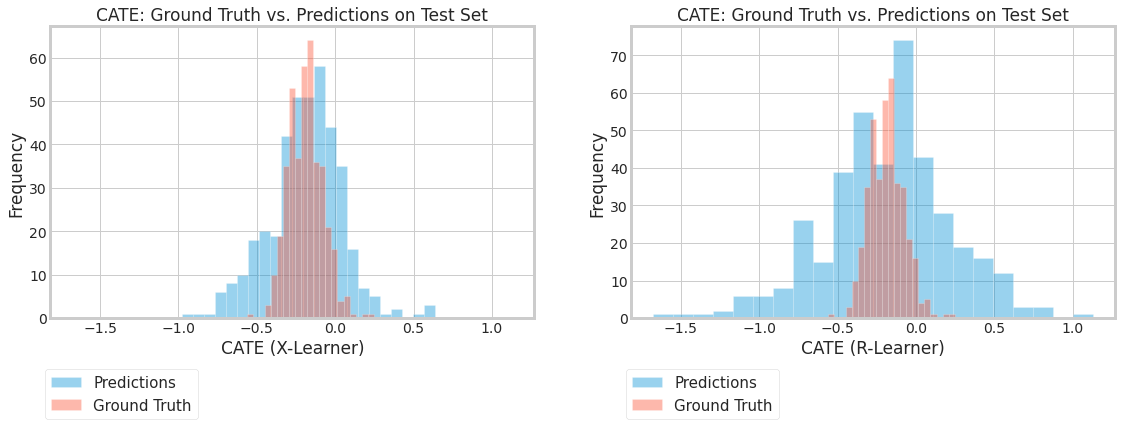


b) Simulated RCT with positive ATE:  



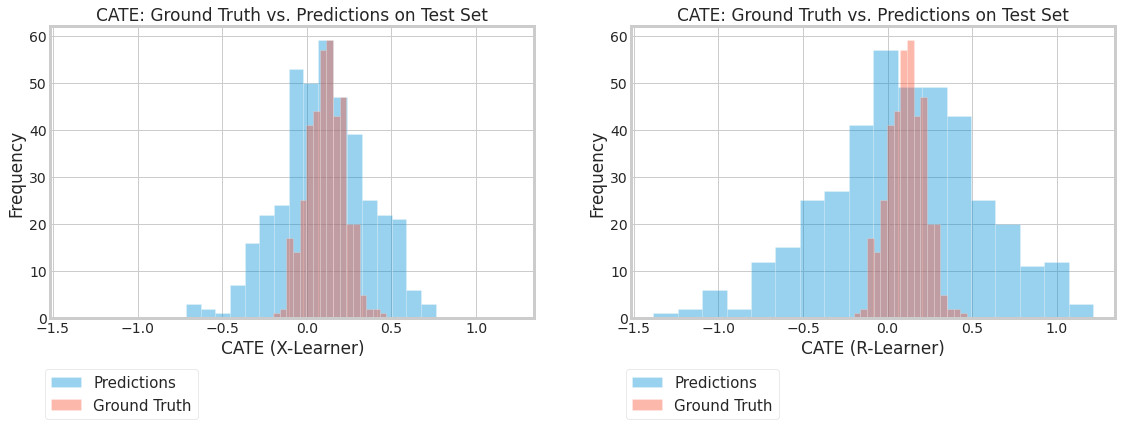


c) Simulated RCT with ATE=0.0 (approximately):  



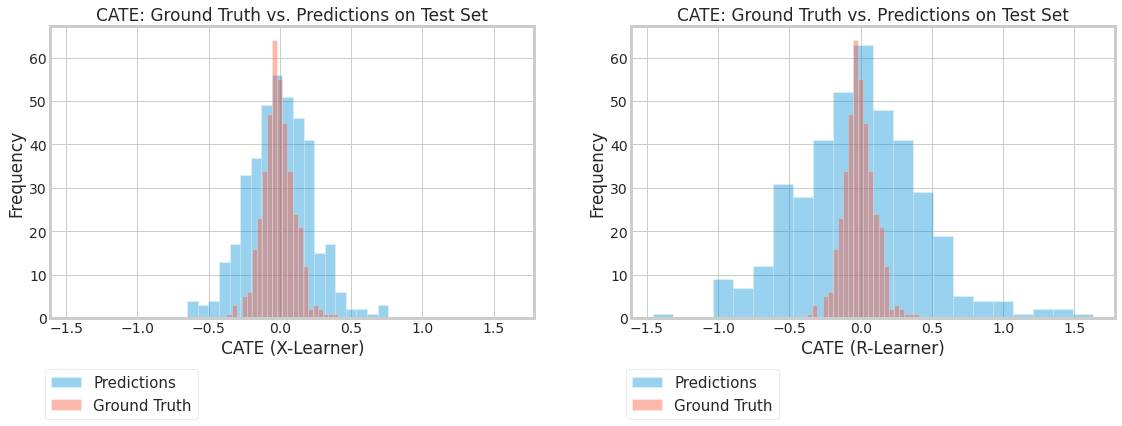

In [ ]:
print("The Results are presented for the first Time Step (Monday)","\n")
print("a) Simulated RCT with negative ATE: ","\n")
prediction_output_negATE=predict_cate_ate(train_set=train_test_negATE["train_data"],test_set=train_test_negATE["test_data"],
                                          #Pass the Outcome & Effect Learners to the X-Learner:
                                          xlearner_outcome_learner=XGBClassifier(n_estimators=500,objective='reg:squarederror'),
                                          xlearner_control_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                                          xlearner_treatment_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                                          #Pass the Outcome & Effect Learner to the R-Learner:
                                          rlearner_outcome_learner=XGBClassifier(n_estimators=500,objective='reg:squarederror'),
                                          rlearner_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'))

print("b) Simulated RCT with positive ATE: ","\n")
prediction_output_posATE=predict_cate_ate(train_set=train_test_posATE["train_data"],test_set=train_test_posATE["test_data"],
                                          #Pass the Outcome & Effect Learners to the X-Learner:
                                          xlearner_outcome_learner=XGBClassifier(n_estimators=500,objective='reg:squarederror'),
                                          xlearner_control_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                                          xlearner_treatment_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                                          #Pass the Outcome & Effect Learner to the R-Learner:
                                          rlearner_outcome_learner=XGBClassifier(n_estimators=500,objective='reg:squarederror'),
                                          rlearner_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'))

print("c) Simulated RCT with ATE=0.0 (approximately): ","\n")
prediction_output_noATE=predict_cate_ate(train_set=train_test_noATE["train_data"],test_set=train_test_noATE["test_data"],
                                          #Pass the Outcome & Effect Learners to the X-Learner:
                                          xlearner_outcome_learner=XGBClassifier(n_estimators=500,objective='reg:squarederror'),
                                          xlearner_control_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                                          xlearner_treatment_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                                          #Pass the Outcome & Effect Learner to the R-Learner:
                                          rlearner_outcome_learner=XGBClassifier(n_estimators=500,objective='reg:squarederror'),
                                          rlearner_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'))

In [ ]:
print("Tabular Summary of CATE & ATE Predictions for the first Time Step (Monday): ")

Tabular Summary of CATE & ATE Predictions for the first Time Step (Monday): 


![alt text](https://drive.google.com/uc?id=1plXesV0ap27RMVd-hV7p7R9Dn-cIqdfV)

**Interpretation of the Prediction Results from the sequential Setting (A/B Testing)**<br>
The results in the current setting are similar to the ones from the sequential setting where an e-mail campaign is simulated: the distribution of the predicted CATE by both models has higher variance than the true CATE. Comparing the two models, the variance of the predictions of the X-Learner is lower than the one of the R-Learner. The tabular summary also shows that the the X-Learner achieves lower RMSE values. Therefore, it can be concluded, that in each of the setting so far and the corresponding scenarios the X-Learner outperforms the R-Learner on the prediction of CATE.

The results in terms of APE on the estimation of ATE similarly to the e-mail campaign sequential setting show some inconsistencies with the RMSE values on the CATE predictions. Therefore, regardless of the setting cross-validation tunrs out to be always neccessary.


#### **3.3.2.2. Evaluation of CATE Predictions with T-Risk Metric**

a) Simulated RCT with negative ATE:  



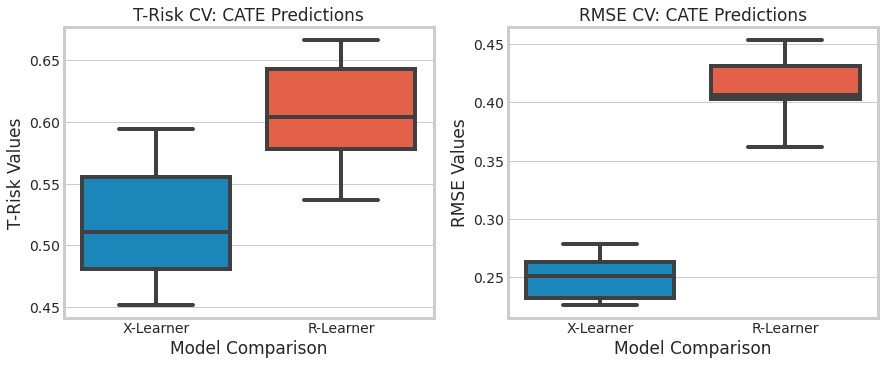




b) Simulated RCT with positive ATE:  



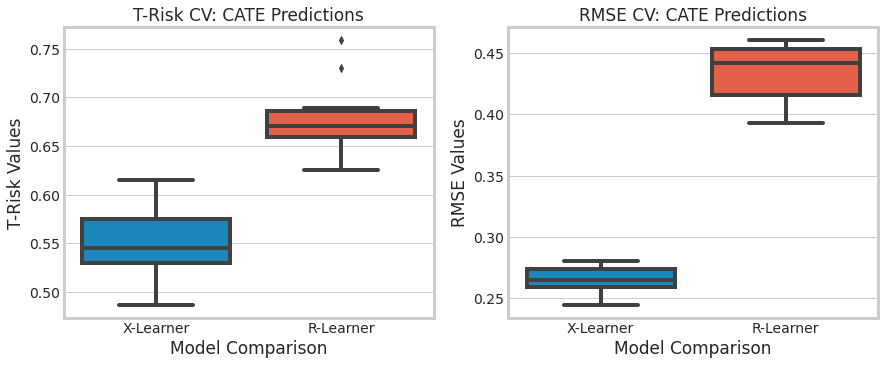




c) Simulated RCT with ATE=0.0:  



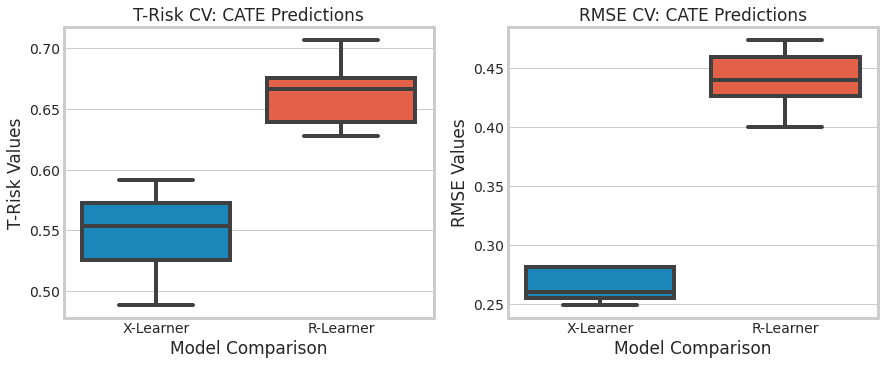

In [ ]:
print("a) Simulated RCT with negative ATE: ","\n")
cv_output_negATE=CV_results(relevant_data=response_frame_negATE[0],n_folds=10,
                            #Pass the Outcome & Effect Learners to the X-Learner:
                            xlearner_outcome_learner=XGBClassifier(n_estimators=500,objective='reg:squarederror'),
                            xlearner_control_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                            xlearner_treatment_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                            #Pass the Outcome & Effect Learner to the R-Learner:
                            rlearner_outcome_learner=XGBClassifier(n_estimators=500,objective='reg:squarederror'),
                            rlearner_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                            sample_folds=True)

print("b) Simulated RCT with positive ATE: ","\n")
cv_output_posATE=CV_results(relevant_data=response_frame_posATE[0],n_folds=10,
                            #Pass the Outcome & Effect Learners to the X-Learner:
                            xlearner_outcome_learner=XGBClassifier(n_estimators=500,objective='reg:squarederror'),
                            xlearner_control_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                            xlearner_treatment_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                            #Pass the Outcome & Effect Learner to the R-Learner:
                            rlearner_outcome_learner=XGBClassifier(n_estimators=500,objective='reg:squarederror'),
                            rlearner_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                            sample_folds=True)

print("c) Simulated RCT with ATE=0.0: ","\n")
cv_output_noATE=CV_results(relevant_data=response_frame_noATE[0],n_folds=10,
                           #Pass the Outcome & Effect Learners to the X-Learner:
                           xlearner_outcome_learner=XGBClassifier(n_estimators=500,objective='reg:squarederror'),
                           xlearner_control_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                           xlearner_treatment_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                           #Pass the Outcome & Effect Learner to the R-Learner:
                           rlearner_outcome_learner=XGBClassifier(n_estimators=500,objective='reg:squarederror'),
                           rlearner_effect_learner=XGBRegressor(n_estimators=500,objective='reg:squarederror'),
                           sample_folds=True)

In [ ]:
print("Tabular summary of CV Results:")

Tabular summary of CV Results:


![alt text](https://drive.google.com/uc?id=1ZPeQEDgiNkBhgST132gHkqD3Bi-84PDs)

**Interpretation of the CV Results**<br>
The results from the 10-Fold CV in the current setting are similar to the CV results in the rest of the settings. Judging by the boxplots visualizing the distribution of the T-rsik values as well as by the mean of the T-risk values from 10-Fold CV in the tabular summary, the conclusion is made that the X-Learner should be chosen over the R-Learner for the estimation of CATE. By chossing the X-Learner, we also pick the model that achieves a lower average APE on the estimation of ATE in each scenario. 

#### **3.3.2.3. Uplift Modelling**

a) Simulated RCT with negative ATE:  



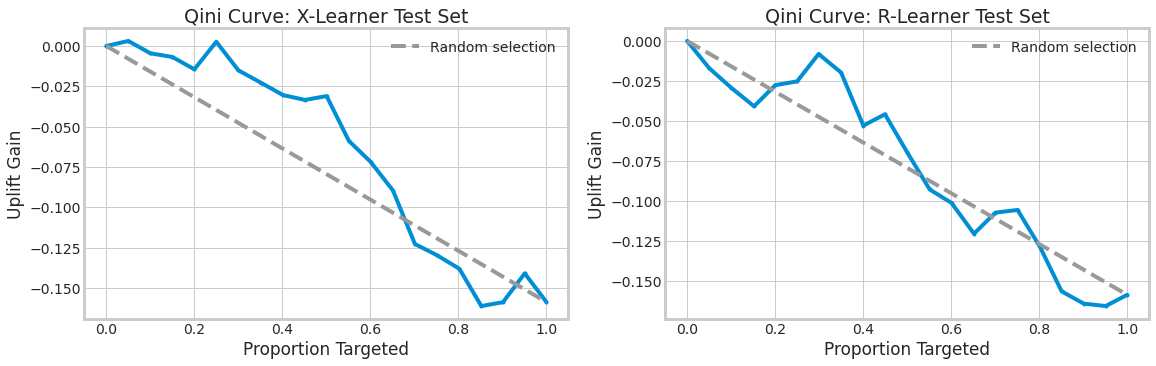




b) Simulated RCT with positive ATE:  



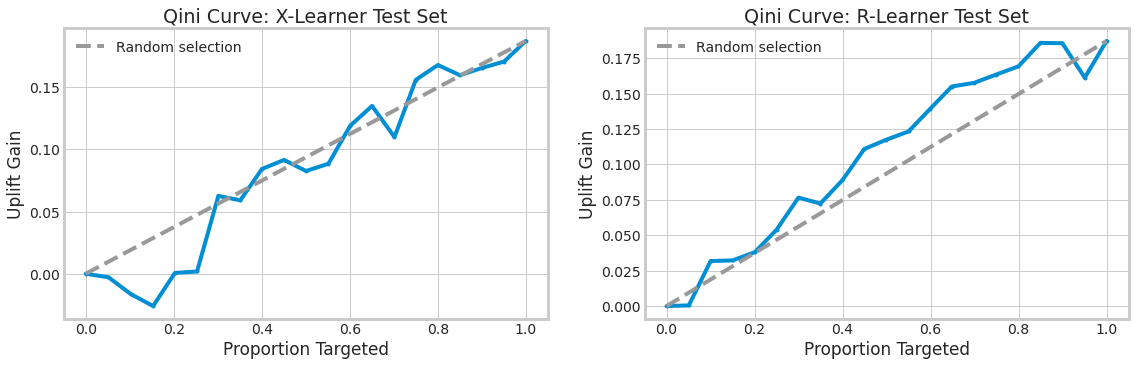




c) Simulated RCT with ATE=0.0:  



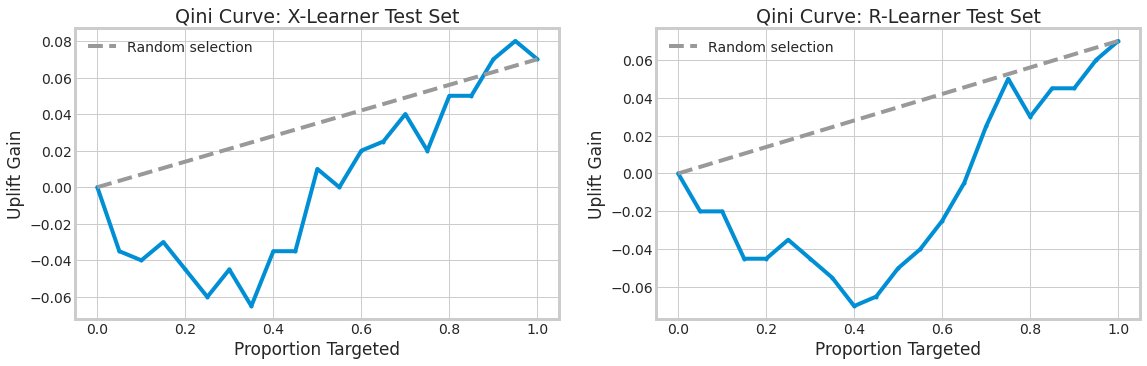

In [ ]:
print("a) Simulated RCT with negative ATE: ","\n")
qini_coefficient_output_negATE=plot_qini_curves(train_data=train_test_negATE["train_data"],
                                         test_data=train_test_negATE["test_data"],
                                         xlearner_predictions=prediction_output_negATE["predictions_xlearner"],
                                        rlearner_predictions=prediction_output_negATE["predictions_rlearner"])

print("b) Simulated RCT with positive ATE: ","\n")
qini_coefficient_output_posATE=plot_qini_curves(train_data=train_test_posATE["train_data"],
                                         test_data=train_test_posATE["test_data"],
                                         xlearner_predictions=prediction_output_posATE["predictions_xlearner"],
                                        rlearner_predictions=prediction_output_posATE["predictions_rlearner"])

print("c) Simulated RCT with ATE=0.0: ","\n")
qini_coefficient_output_noATE=plot_qini_curves(train_data=train_test_noATE["train_data"],
                                         test_data=train_test_noATE["test_data"],
                                         xlearner_predictions=prediction_output_noATE["predictions_xlearner"],
                                        rlearner_predictions=prediction_output_noATE["predictions_rlearner"])

In [ ]:
print("Tabular Summary of Qini Coefficient on Train & Test Set before Hyperparameter Tuning: ")

Tabular Summary of Qini Coefficient on Train & Test Set before Hyperparameter Tuning: 


![alt text](https://drive.google.com/uc?id=1zUoaofnKL1uQ6GZAIFhyqZGeCnJP8IK5)

**Interpretation of the Qini Curves**<br>
The models in this setting achieve similar results to the rest of the settings. Therefore, the problem with the qini coefficient can be established both in the fixed-time setting and the sequential setting in each of the scenarios (RCT with 3 different ATE values.) 

**Hyperparameter Tuning: Evaluation Criteria=Area under the Qini Curve**<br>

In [ ]:
#Hyperparameter Optimization:

#RCT with negative ATE:
#X-Learner:
hp_negATE=hyperparameter_tuning(train_set=train_test_negATE["train_data"],
                                 test_set=train_test_negATE["test_data"],
                                 learner_to_test="X-Learner",
                                 num_trials=100)
results_hp_negATE_x=hp_negATE.run_study()

#R-Learner:
hp_negATE=hyperparameter_tuning(train_set=train_test_negATE["train_data"],
                                 test_set=train_test_negATE["test_data"],
                                 learner_to_test="R-Learner",
                                 num_trials=100)
results_hp_negATE_r=hp_negATE.run_study()

#RCT with positive ATE:
#X-Learner:
hp_posATE=hyperparameter_tuning(train_set=train_test_posATE["train_data"],
                                 test_set=train_test_posATE["test_data"],
                                 learner_to_test="X-Learner",
                                 num_trials=100)
results_hp_posATE_x=hp_negATE.run_study()

#R-Learner:
hp_posATE=hyperparameter_tuning(train_set=train_test_posATE["train_data"],
                                 test_set=train_test_posATE["test_data"],
                                 learner_to_test="R-Learner",
                                 num_trials=100)
results_hp_posATE_r=hp_negATE.run_study()

#RCT with ATE=0.0:
#X-Learner:
hp_noATE=hyperparameter_tuning(train_set=train_test_noATE["train_data"],
                                 test_set=train_test_noATE["test_data"],
                                 learner_to_test="X-Learner",
                                 num_trials=100)
results_hp_noATE_x=hp_noATE.run_study()

#R-Learner:
hp_noATE=hyperparameter_tuning(train_set=train_test_noATE["train_data"],
                                 test_set=train_test_noATE["test_data"],
                                 learner_to_test="R-Learner",
                                 num_trials=100)
results_hp_noATE_r=hp_noATE.run_study()


In [ ]:
print("Tabular Summary of Qini Coefficient after Hyperparameter Tuning")

Tabular Summary of Qini Coefficient after Hyperparameter Tuning


![alt text](https://drive.google.com/uc?id=1kyAfo3IRQki-QGM4nFuz78A7s1Z8t-Mz)


Results after Hyperparameter Tuning on the data from Monday:  

a) Simulated RCT with negative ATE:  



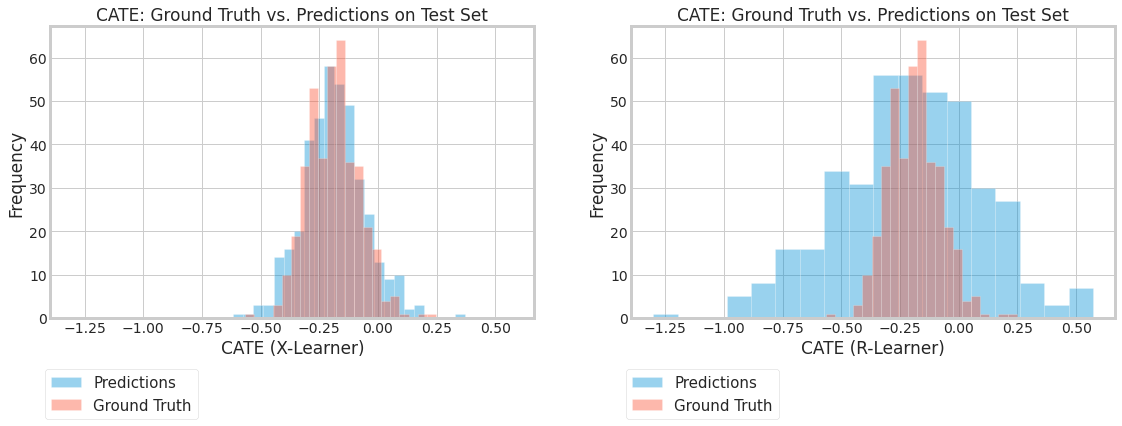


b) Simulated RCT with positive ATE:  



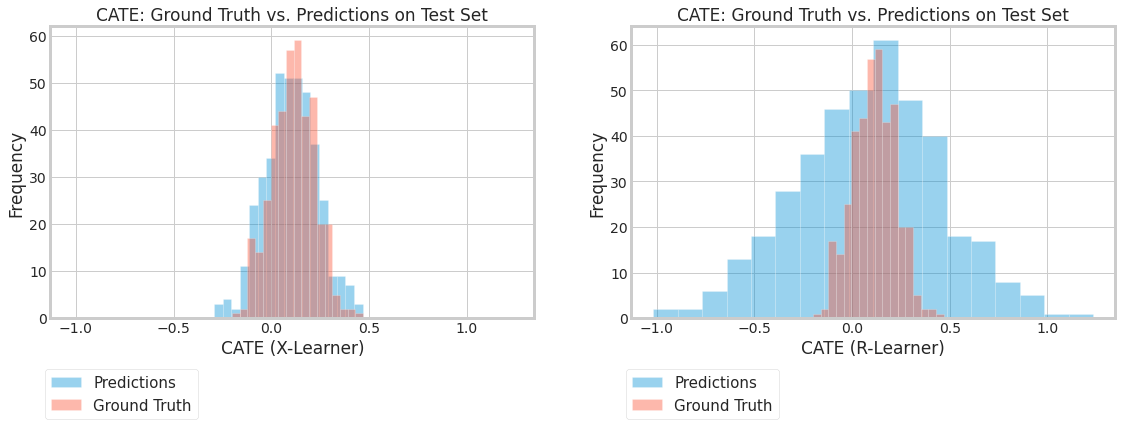


c) Simulated RCT with ATE=0.0 (approximately):  



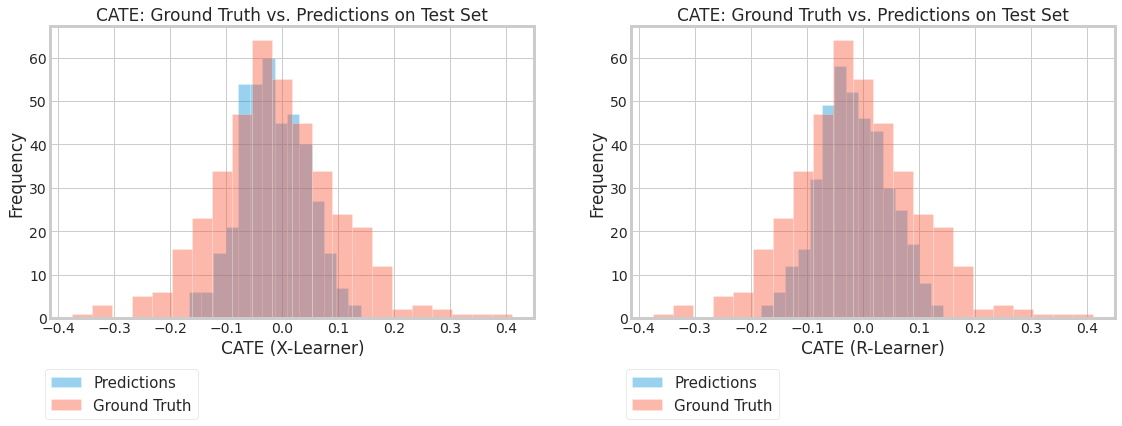

In [ ]:
print("Results after Hyperparameter Tuning on the data from Monday: ","\n")
print("a) Simulated RCT with negative ATE: ","\n")

prediction_output_negATE=predict_cate_ate(train_set=train_test_negATE["train_data"],test_set=train_test_negATE["test_data"],
                                          #Pass the Outcome & Effect Learners to the X-Learner:
                                          xlearner_outcome_learner=XGBClassifier(max_depth=350, 
                                                                                 learning_rate=0.0798,n_estimators=900,
                                                                                 booster="gbtree",colsample_bytree=0.7,
                                                                                 reg_alpha=0.0,reg_lambda=0.037,
                                                                                 importance_type="total_cover",objective='reg:squarederror'),
                                          xlearner_control_effect_learner=XGBRegressor(max_depth=350, 
                                                                                 learning_rate=0.0798,n_estimators=900,
                                                                                 booster="gbtree",colsample_bytree=0.7,
                                                                                 reg_alpha=0.0,reg_lambda=0.037,
                                                                                 importance_type="total_cover",objective='reg:squarederror'),
                                          xlearner_treatment_effect_learner=XGBRegressor(max_depth=350, 
                                                                                 learning_rate=0.0798,n_estimators=900,
                                                                                 booster="gbtree",colsample_bytree=0.7,
                                                                                 reg_alpha=0.0,reg_lambda=0.037,
                                                                                 importance_type="total_cover",objective='reg:squarederror'),
                                          
                                          #Pass the Outcome & Effect Learner to the R-Learner:
                                          rlearner_outcome_learner=XGBClassifier(max_depth=1000, 
                                                                                 learning_rate=0.0862,n_estimators=850,
                                                                                 booster="gbtree",colsample_bytree=0.4,
                                                                                 reg_alpha=0.0,reg_lambda=0.18,
                                                                                 importance_type="gain",objective='reg:squarederror'),
                                          rlearner_effect_learner=XGBRegressor(max_depth=1000, 
                                                                                 learning_rate=0.0862,n_estimators=850,
                                                                                 booster="gbtree",colsample_bytree=0.4,
                                                                                 reg_alpha=0.0,reg_lambda=0.18,
                                                                                 importance_type="gain",objective='reg:squarederror'))


print("b) Simulated RCT with positive ATE: ","\n")
prediction_output_posATE=predict_cate_ate(train_set=train_test_posATE["train_data"],test_set=train_test_posATE["test_data"],
                                          #Pass the Outcome & Effect Learners to the X-Learner:
                                          xlearner_outcome_learner=XGBClassifier(max_depth=810, 
                                                                                 learning_rate=0.0588,n_estimators=450,
                                                                                 booster="gbtree",colsample_bytree=0.7,
                                                                                 reg_alpha=0.0,reg_lambda=0.122,
                                                                                 importance_type="total_gain",objective='reg:squarederror'),
                                          xlearner_control_effect_learner=XGBRegressor(max_depth=810, 
                                                                                 learning_rate=0.0588,n_estimators=450,
                                                                                 booster="gbtree",colsample_bytree=0.7,
                                                                                 reg_alpha=0.0,reg_lambda=0.122,
                                                                                 importance_type="total_gain",objective='reg:squarederror'),
                                          xlearner_treatment_effect_learner=XGBRegressor(max_depth=810, 
                                                                                 learning_rate=0.0588,n_estimators=450,
                                                                                 booster="gbtree",colsample_bytree=0.7,
                                                                                 reg_alpha=0.0,reg_lambda=0.122,
                                                                                 importance_type="total_gain",objective='reg:squarederror'),
                                          
                                          #Pass the Outcome & Effect Learner to the R-Learner:
                                          rlearner_outcome_learner=XGBClassifier(max_depth=380, 
                                                                                 learning_rate=0.085,n_estimators=500,
                                                                                 booster="gbtree",colsample_bytree=0.7,
                                                                                 reg_alpha=0.0,reg_lambda=0.177,
                                                                                 importance_type="weight",objective='reg:squarederror'),
                                          rlearner_effect_learner=XGBRegressor(max_depth=380, 
                                                                                 learning_rate=0.085,n_estimators=500,
                                                                                 booster="gbtree",colsample_bytree=0.7,
                                                                                 reg_alpha=0.0,reg_lambda=0.177,
                                                                                 importance_type="weight",objective='reg:squarederror'))


print("c) Simulated RCT with ATE=0.0 (approximately): ","\n")
prediction_output_noATE=predict_cate_ate(train_set=train_test_noATE["train_data"],test_set=train_test_noATE["test_data"],
                                          #Pass the Outcome & Effect Learners to the X-Learner:
                                          xlearner_outcome_learner=XGBClassifier(max_depth=130, 
                                                                                 learning_rate=0.0913,n_estimators=950,
                                                                                 booster="gblinear",colsample_bytree=0.7,
                                                                                 reg_alpha=0.0,reg_lambda=0.146,
                                                                                 importance_type="total_gain",objective='reg:squarederror'),
                                          xlearner_control_effect_learner=XGBRegressor(max_depth=130, 
                                                                                 learning_rate=0.0913,n_estimators=950,
                                                                                 booster="gblinear",colsample_bytree=0.7,
                                                                                 reg_alpha=0.0,reg_lambda=0.146,
                                                                                 importance_type="total_gain",objective='reg:squarederror'),
                                          xlearner_treatment_effect_learner=XGBRegressor(max_depth=130, 
                                                                                 learning_rate=0.0913,n_estimators=950,
                                                                                 booster="gblinear",colsample_bytree=0.7,
                                                                                 reg_alpha=0.0,reg_lambda=0.146,
                                                                                 importance_type="total_gain",objective='reg:squarederror'),
                                         
                                          #Pass the Outcome & Effect Learner to the R-Learner:
                                          rlearner_outcome_learner=XGBClassifier(max_depth=450, 
                                                                                 learning_rate=0.0165,n_estimators=950,
                                                                                 booster="gblinear",colsample_bytree=0.6,
                                                                                 reg_alpha=0.0,reg_lambda= 0.139,
                                                                                 importance_type="total_gain",objective='reg:squarederror'),
                                          rlearner_effect_learner=XGBRegressor(max_depth=450, 
                                                                                 learning_rate=0.0165,n_estimators=950,
                                                                                 booster="gblinear",colsample_bytree=0.6,
                                                                                 reg_alpha=0.0,reg_lambda= 0.139,
                                                                                 importance_type="total_gain",objective='reg:squarederror'))

**Interpretation of the Results after Hyperparameter Optimization**<br>
The tabular summary of results from the hyperparameter tuning in this setting as well as the histograms showing the predicted vs. the true distribution of CATE show similar results to the ones achieved so far: no improvement can be achieved in terms of  the qini coefficient and no clear conclusion can be made whether the hyperparameter tuning of the qini coefficient leads more or less accurate predictions of CATE.

### **Conclusion and Outlook**
This research aimed at highlighting the challenges that marketing practitioners face when estimating ATE and CATE. Among the settings included in this research, the estimation of ATE and CATE turns out to be more challenging in the sequential setting where a small proportion of the entire dataset is used. In both cases of the sequential testing (e-mail campaign and A/B testing) the continuous monitoring could be stopped at the first time step (Moday). The results showed that cross-validation is neccessary in order to obtain more consistent and reliable results when estimating ATE and CATE. Furthermore, the optimization of the models with respect to the Area under the Qini Curve turned out to be quite challenging as the models achieved a very low Qini Coefficient on the test set and a high one on the train set in each setting. In addition to that, hyperparammeter tuning did not improve the results in terms of the Qini Score on the test set. Furthermore, no specific conclusion could be made whether the predictions of CATE after the hyperparameter optimization become more or less accurate compared to the predictions of CATE before hyperparameter tuning. Future work, can focus on finding solutions to the challenges found in this research. In this context, other machine learning models like neural networks can be applied in order to control whether they could achieve better results in terms of the Qini Coefficient on the test set. Furthermore, it could also be examined whether applying an oversampling stragety, for example SMOTE, in sequential testing at each time step in order to obtain more data than the actual response flow would lead to a lower error in the estimates of ATE and CATE. 

**References**

Abhishek, Vineet, and Shie Mannor. 2019. “A Nonparametric Sequential Test for Online Randomized Experiments.” 26th International World Wide Web Conference 2017, WWW 2017 Companion, 610–16. https://doi.org/10.1145/3041021.3054196.<br>

Blake, Thomas, Chris Nosko, and Steven Tadelis. 2015. “Consumer Heterogeneity and Paid Search Effectiveness: A Large-Scale Field Experiment.” Econometrica. https://doi.org/10.3982/ecta12423.<br>

Chan, David, Rong Ge, Ori Gershony, Tim Hesterberg, and Diane Lambert. 2010. “Evaluating Online Ad Campaigns in a Pipeline: Causal Models at Scale.” Proceedings of the ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, 7–15. https://doi.org/10.1145/1835804.1835809.<br>

Craig A Rolling and Yuhong Yang. Model selection for estimating treatment effects. Journal of the Royal Statistical Society: Series B (Statistical
Methodology), 76(4):749–769, 2013.<br>

Deng, Alex. 2015. “Objective Bayesian Two Sample Hypothesis Testing for Online Controlled Experiments.” In WWW 2015 Companion - Proceedings of the 24th International Conference on World Wide Web. https://doi.org/10.1145/2740908.2742563.<br>

Kharitonov, Eugene, Aleksandr Vorobev, Craig MacDonald, Pavel Serdyukov, and Iadh Ounis. 2015. “Sequential Testing for Early Stopping of Online Experiments.” SIGIR 2015 - Proceedings of the 38th International ACM SIGIR Conference on Research and Development in Information Retrieval, 473–82. https://doi.org/10.1145/2766462.2767729.<br>

München, Ludwig-maximilians-universität, Ludwig-maximilians-universität München, Felix D Schönbrodt, Eric-jan Wagenmakers, Michael Zehetleitner, and Marco Perugini. 2015. “Sequential Hypothesis Testing With Bayes Factors : Sequential Hypothesis Testing With Bayes Factors: Efficiently Testing Mean Differences.”<br>

Rubin, Donald B., and Richard P. Waterman. 2006. “Estimating the Causal Effects of Marketing Interventions Using Propensity Score Methodology.” Statistical Science 21 (2): 206–22. https://doi.org/10.1214/088342306000000259.<br>

Thistlethwaite, Donald L., and Donald T. Campbell. 1960. “Regression-Discontinuity Analysis: An Alternative to the Ex Post Facto Experiment.” Journal of Educational Psychology. https://doi.org/10.1037/h0044319.<br>

Varian, Hal R. 2016. “Causal Inference in Economics and Marketing.” Proceedings of the National Academy of Sciences of the United States of America 113 (27): 7310–15. https://doi.org/10.1073/pnas.1510479113.